 # **Task3**

 ### **Stage 0:** _Importing libs. Adding plotter class and sys functions_

In [23]:
import json
import hashlib
from pathlib import Path

# import sys
import pickle
from typing import Tuple, Optional, Any, Callable
from functools import wraps

# data
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import matplotlib.axes as mpl_axes

# data workflows
import tqdm
import scipy
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, auc

 ##### **_Constants_**

In [24]:
DPI = 150
SAVE_DIR = "res"
COLORS = ["red", "green", "blue"]
EDGECOLOR = "#11111b"
STYLES = ["o", "s", "^"]

CACHED = True
RECACHE = True
CLEAR_CACHE = False

CALC_COV = True
CALC_GRID = True

CALC_T3 = True
CALC_T4T5 = True
CALC_T6 = True

 ##### **_Plotter interface_**

In [25]:
class Plotter:
    def __init__(
        self, nrows: int = 1, ncols: int = 1, figsize: Tuple[int, int] = (6, 6)
    ) -> None:
        self.fig, self.axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        self.nrows = nrows
        self.ncols = ncols
        self.size = self.nrows * self.ncols

        if nrows == 1 and ncols == 1:
            self.axes = np.array([self.axes])
        elif nrows == 1 or ncols == 1:
            self.axes = self.axes.reshape(-1)
        else:
            self.axes = self.axes.flatten()

        self.position = None

    def __getitem__(self, index: int):
        return self._get_axes_by_index(index)

    def __getattr__(self, name: str):
        if hasattr(mpl_axes.Axes, name):

            def dynamic_method(
                *args,
                idx: Optional[int] = None,
                irow: Optional[int] = None,
                icol: Optional[int] = None,
                **kwargs,
            ):
                ax = (
                    self._get_axis(idx, irow, icol)
                    if self.position is None
                    else self.position
                )
                method = getattr(ax, name)
                return method(*args, **kwargs)

            return dynamic_method

        raise AttributeError(
            f'"{type(self).__name__}" object has no attribute "{name}"'
        )

    def _get_axes_by_index(self, idx: int = 0) -> Any:
        return self.axes[idx]

    def _get_axes_by_coords(self, irow: int = 0, icol: int = 0) -> Any:
        idx = irow * self.ncols + icol
        return self.axes[idx]

    def _get_axis(
        self,
        idx: Optional[int] = None,
        irow: Optional[int] = None,
        icol: Optional[int] = None,
    ) -> Any:
        if idx is not None:
            return self._get_axes_by_index(idx)
        elif irow is not None and icol is not None:
            return self._get_axes_by_coords(irow, icol)
        else:
            raise ValueError("ERROR: Wrong indexation!")

    def set_position(
        self,
        idx: Optional[int] = None,
        irow: Optional[int] = None,
        icol: Optional[int] = None,
    ) -> None:
        self.position = self._get_axis(idx, irow, icol)

    def del_position(self) -> None:
        self.position = None

    def dataset_visual(self, X, y, colors, styles, edgecolor, alpha=0.6) -> None:
        if self.size != len(X.columns) ** 2:
            raise ValueError("ERROR: Features count not matched with figure size!")

        columns = X.columns
        classes = y.unique()
        for i, rowname in enumerate(columns):
            for j, colname in enumerate(columns):
                self.set_position(irow=i, icol=j)

                for k, class_value in enumerate(classes):
                    class_mask = y == class_value
                    if i == j:
                        local_data = X[class_mask][colname]
                        kde = scipy.stats.gaussian_kde(local_data)
                        x = np.linspace(local_data.min(), local_data.max(), 100)
                        self.fill_between(
                            x,
                            np.zeros_like(x),
                            kde(x),
                            color=colors[k],
                            alpha=alpha,
                            label=f'class "{class_value}"',
                        )
                        continue

                    self.scatter(
                        X[class_mask][colname],
                        X[class_mask][rowname],
                        marker=styles[k],
                        color=colors[k],
                        edgecolor=edgecolor,
                        alpha=alpha,
                        label=f'class "{class_value}"',
                    )

                if i == j:
                    self.labels("value", "count", colname)
                else:
                    self.labels(colname, rowname, "")

                self.grid(True, alpha=0.3)
                self.legend()

    def labels(
        self,
        xlabel: str,
        ylabel: str,
        title: str,
        idx: Optional[int] = None,
        irow: Optional[int] = None,
        icol: Optional[int] = None,
    ) -> Any:
        ax = self._get_axis(idx, irow, icol) if self.position is None else self.position
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        return ax

    def tight_layout(self) -> None:
        self.fig.tight_layout()

    def save(self, path: str, dpi: int = 300, **kwargs) -> None:
        self.fig.savefig(path, dpi=dpi, **kwargs)

    def show(self) -> None:
        self.fig.show()

 ##### **_Cache manager_**

In [26]:
class CacheManager:
    def __init__(self, cache_dir: str = "cache"):
        self.cache_dir = Path(cache_dir)
        self.metadata_file = self.cache_dir / "cache_metadata.json"
        self.cache_dir.mkdir(exist_ok=True)
        self._load_metadata()
    
    def _load_metadata(self):
        if self.metadata_file.exists():
            with open(self.metadata_file, 'r', encoding='utf-8') as f:
                self.metadata = json.load(f)
        else:
            self.metadata = {}
    
    def _save_metadata(self):
        with open(self.metadata_file, 'w', encoding='utf-8') as f:
            json.dump(self.metadata, f, indent=2, ensure_ascii=False)
    
    def _generate_cache_id(self, func_name: str, args: tuple, kwargs: dict) -> str:
        args_str = str(args) + str(sorted(kwargs.items()))
        
        hash_obj = hashlib.md5(args_str.encode())
        return f"{func_name}_{hash_obj.hexdigest()[:8]}"
    
    def _generate_checksum(self, args: tuple, kwargs: dict) -> str:
        args_str = str(args) + str(sorted(kwargs.items()))
        return hashlib.md5(args_str.encode()).hexdigest()
    
    def get_cache_path(self, cache_id: str, additional_name: Optional[str] = None) -> Path:
        if additional_name:
            filename = f"{additional_name}_{cache_id}.pkl"
        else:
            filename = f"{cache_id}.pkl"
        return self.cache_dir / filename
    
    def is_cache_valid(self, cache_path: str, current_checksum: str) -> bool:
        return (cache_path in self.metadata and 
                self.metadata[cache_path] == current_checksum)
    
    def update_cache_metadata(self, cache_path: str, checksum: str):
        self.metadata[str(cache_path)] = checksum
        self._save_metadata()
    
    def clear_cache(self):
        for file in self.cache_dir.glob("*.pkl"):
            file.unlink()
        self.metadata = {}
        self._save_metadata()



In [27]:
cache_manager = CacheManager()
if CLEAR_CACHE or RECACHE:
    cache_manager.clear_cache()


def cached(additional_name: Optional[str] = None):
    def decorator(func: Callable) -> Callable:
        @wraps(func)
        def wrapper(*args, **kwargs) -> Any:
            cache_id = cache_manager._generate_cache_id(func.__name__, args, kwargs)
            current_checksum = cache_manager._generate_checksum(args, kwargs)
            cache_path = cache_manager.get_cache_path(cache_id, additional_name)
            
            if CACHED and not RECACHE:
                if cache_path.exists() and cache_manager.is_cache_valid(str(cache_path), current_checksum):
                    try:
                        with open(cache_path, 'rb') as f:
                            print(f"\033[90m> Loading cached result for {func.__name__}\033[0m")
                            return pickle.load(f)
                    except (pickle.PickleError, EOFError):
                        print("\033[90m> Cache file corrupted, recalculating...\033[0m")
                
                print(f"\033[90m> Calculating result for {func.__name__}...\033[0m")
                result = func(*args, **kwargs)
                
                with open(cache_path, 'wb') as f:
                    pickle.dump(result, f)
                cache_manager.update_cache_metadata(str(cache_path), current_checksum)
            elif RECACHE and CACHED:
                print(f"\033[90m> Calculating result for {func.__name__}...\033[0m")
                result = func(*args, **kwargs)

                with open(cache_path, 'wb') as f:
                    pickle.dump(result, f)
                cache_manager.update_cache_metadata(str(cache_path), current_checksum)
            else:
                print(f"\033[90m> Calculating result for {func.__name__}...\033[0m")
                result = func(*args, **kwargs)
            
            return result
        
        return wrapper
    return decorator

 ##### **_Data statistics_**

In [28]:
@cached()
def data_stats(data1, data2) -> Any:
    Pearson_v, Pearson_pv = scipy.stats.pearsonr(data1, data2)
    spearman_v, spearman_pv = scipy.stats.spearmanr(data1, data2)

    return np.array([Pearson_v, Pearson_pv, spearman_v, spearman_pv])


@cached()
def get_cov_matrixes(df, features, classes):
    stats = np.zeros((len(features), len(features), (len(classes) + 1) * 4))

    for i, iparam in enumerate(features):
        for j, jparam in enumerate(features):
            data = np.array(df[[iparam, jparam, "target"]])

            stats[i, j, 0:4] = data_stats(data[..., 0], data[..., 1])

            for k, group in enumerate(classes):
                data_by_class = data[data[..., -1] == k]

                stats[i, j, (k + 1) * 4 : (k + 2) * 4] = data_stats(
                    data_by_class[..., 0], data_by_class[..., 1]
                )

    return stats

 ### **Stage 1 (task 1):** _Calculating data, correlations and visualizations_

 ##### **_Create data_**

In [29]:
np.random.seed(42)
n_samples = 100
n_features = 8
n_classes = 3

centers = [
    [+1.0] * 8,
    [-1.0] * 8,
    [+1.0, -1.0] * 4,
]

cluster_std = np.random.uniform(0.2, 1.3, size=len(centers))

COLUMNS = [f"feature_{i + 1}" for i in range(n_features)]


@cached("base_df")
def create_dataframe(n_samples, n_features, n_classes, centers, cluster_std):
    X, y = make_blobs(
        n_samples=n_samples * n_classes,
        n_features=n_features,
        centers=centers,
        cluster_std=cluster_std,
        random_state=42,
    )

    df = pd.DataFrame(X, columns=COLUMNS)
    df["target"] = y

    return df


df1 = create_dataframe(n_samples, n_features, n_classes, centers, cluster_std)

print(f"Размерность df1: {df1.shape}")
print(f"Количество классов: {len(df1['target'].unique())}")
print("Количество объектов в каждом классе:")
print(df1["target"].value_counts().sort_index())
print(df1.describe())

> Calculating result for create_dataframe...
Размерность df1: (300, 9)
Количество классов: 3
Количество объектов в каждом классе:
target
0    100
1    100
2    100
Name: count, dtype: int64
        feature_1   feature_2   feature_3   feature_4   feature_5   feature_6  \
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000   
mean     0.340502   -0.209323    0.326075   -0.247926    0.378597   -0.295301   
std      1.307584    1.350948    1.354599    1.358119    1.194591    1.323019   
min     -4.113724   -4.019634   -4.181639   -4.578223   -3.483767   -4.608114   
25%     -0.503065   -1.204549   -0.604756   -1.270989   -0.240204   -1.286196   
50%      0.670036   -0.110153    0.577908   -0.169612    0.561793   -0.207895   
75%      1.183011    0.810645    1.333677    0.823693    1.191773    0.746950   
max      3.425145    3.357849    3.110626    2.664728    3.084854    2.340546   

        feature_7   feature_8      target  
count  300.000000  300.000000  300.0

 ##### **_Calc correlations_**

> Calculating result for get_cov_matrixes...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating result for data_stats...
> Calculating resul

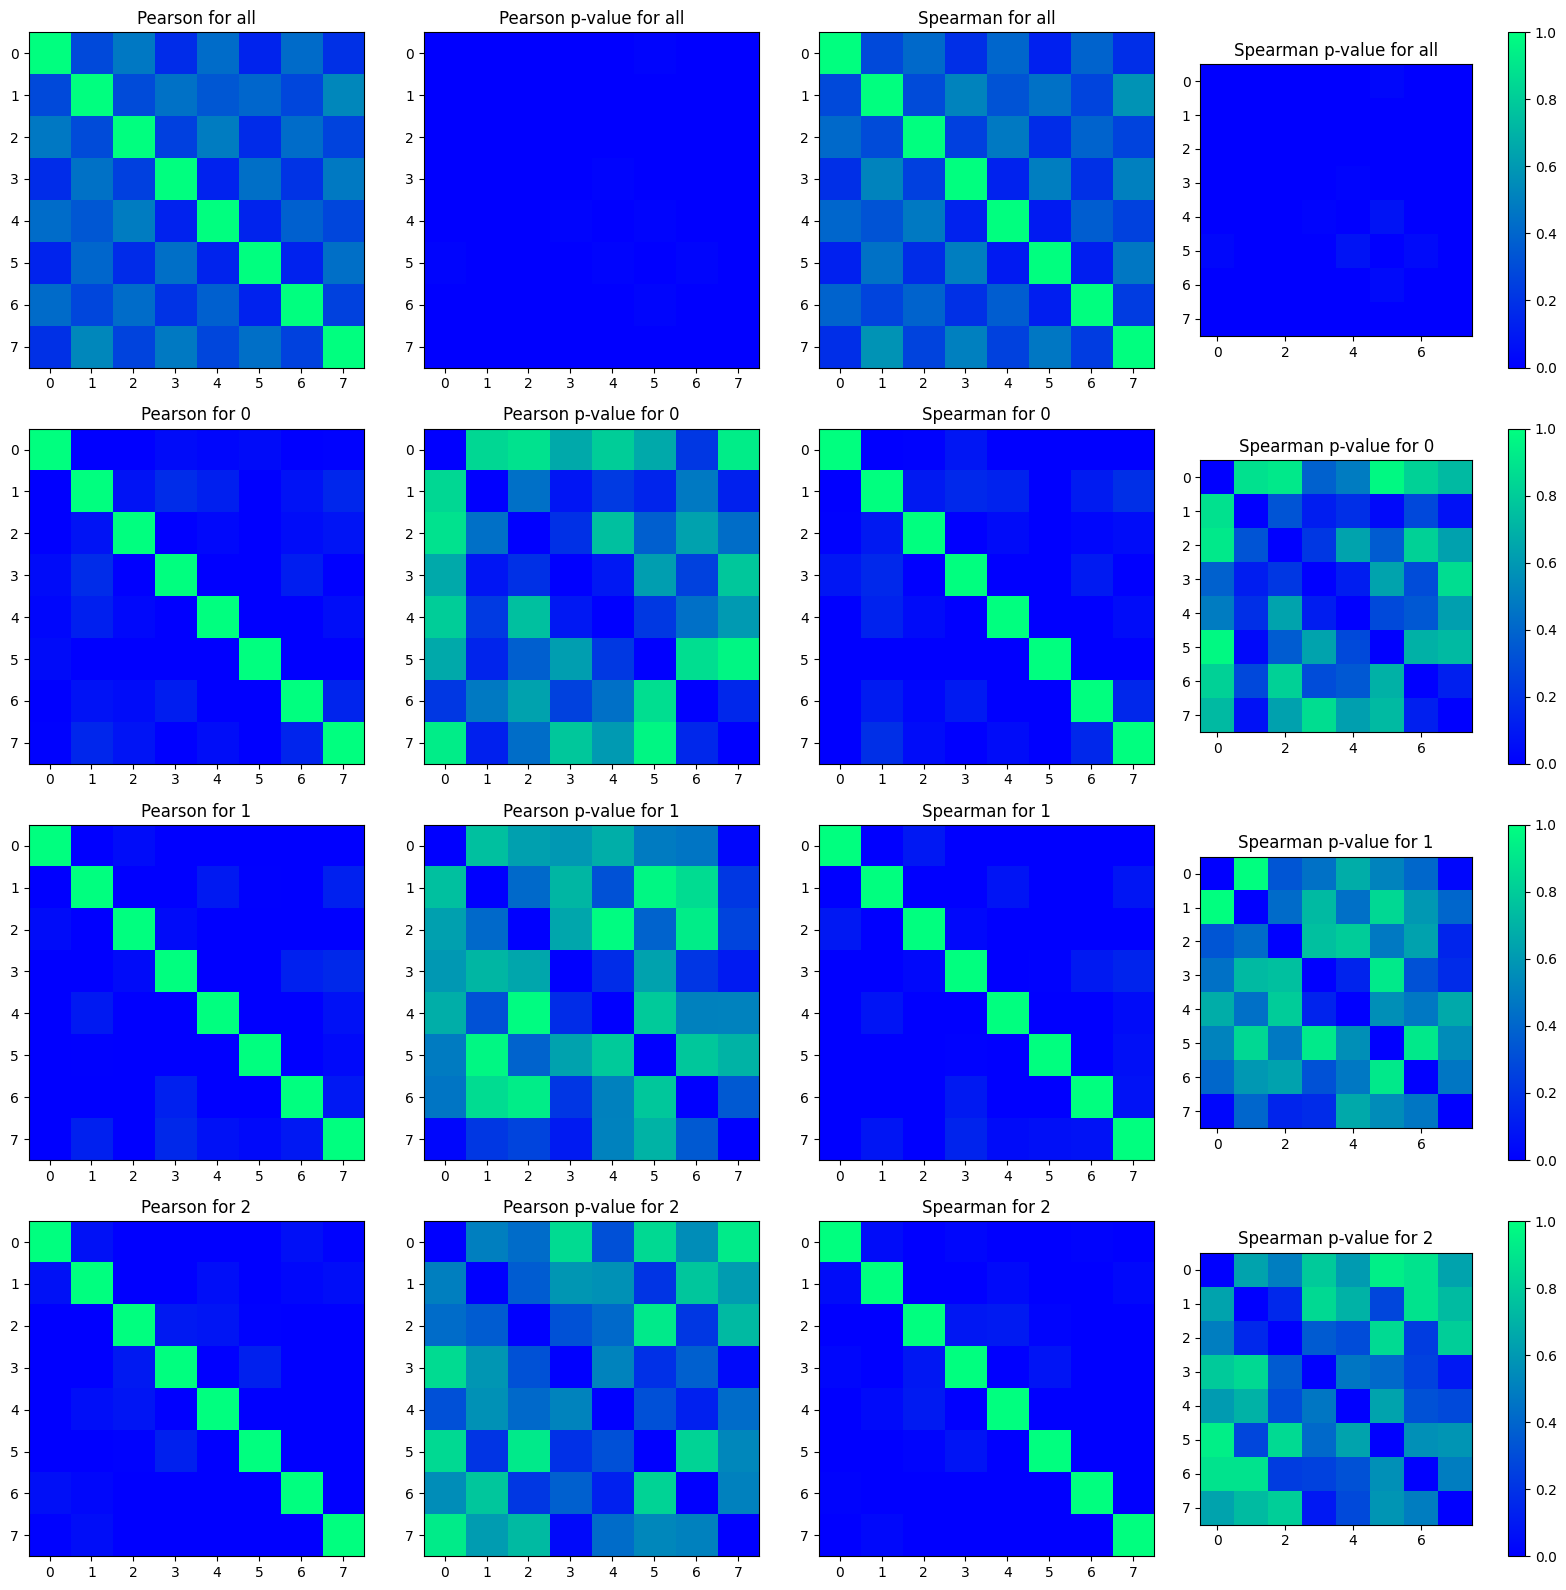

In [30]:
if CALC_COV:
    cov_matrixes = get_cov_matrixes(df1, COLUMNS, [0, 1, 2])

    plotter = Plotter(nrows=4, ncols=4, figsize=(16, 16))

    class_names = ["all", "0", "1", "2"]
    for i in range(4):
        plotter.set_position(idx=i * 4)
        plotter.imshow(cov_matrixes[..., i * 4], cmap="winter", vmin=0.0, vmax=1.0)
        plotter.labels("", "", f"Pearson for {class_names[i]}")

        plotter.set_position(idx=i * 4 + 1)
        plotter.imshow(
            cov_matrixes[..., i * 4 + 1], cmap="winter", vmin=0.0, vmax=1.0
        )
        plotter.labels("", "", f"Pearson p-value for {class_names[i]}")

        plotter.set_position(idx=i * 4 + 2)
        plotter.imshow(
            cov_matrixes[..., i * 4 + 2], cmap="winter", vmin=0.0, vmax=1.0
        )
        plotter.labels("", "", f"Spearman for {class_names[i]}")

        plotter.set_position(idx=i * 4 + 3)
        im = plotter.imshow(
            cov_matrixes[..., i * 4 + 3], cmap="winter", vmin=0.0, vmax=1.0
        )
        plotter.labels("", "", f"Spearman p-value for {class_names[i]}")

        cbar = plotter.fig.colorbar(
            im, ax=plotter.position, orientation="vertical", pad=0.1
        )

    plotter.tight_layout()
    plotter.save("res/corelations.png")


    all_data = []
    groups = []
    classes = [0, 1, 2]

    for k_log in range(len(classes) + 1):
        group = classes[k_log - 1] if k_log > 0 else "all"
        groups.append(group)
        data = {
            "Pair": [],
            "Pearson": [],
            "Pearson p-value": [],
            "Spearman": [],
            "Spearman p-value": [],
        }
        local_matrix = cov_matrixes[..., (k_log * 4) : (k_log + 1) * 4]
        elems = ["Pearson", "Pearson p-value", "Spearman", "Spearman p-value"]
        for i, iparam in enumerate(COLUMNS):
            for j, jparam in enumerate(COLUMNS):
                data["Pair"].append(f"{iparam} x {jparam}")
                data["Pearson"].append(local_matrix[i, j, 0])
                data["Pearson p-value"].append(local_matrix[i, j, 1])
                data["Spearman"].append(local_matrix[i, j, 2])
                data["Spearman p-value"].append(local_matrix[i, j, 3])
        data = pd.DataFrame(data)
        data.to_csv(f"res/stats_for_{group}.csv", index=False)

        all_data.append(data)


    pd.set_option("display.max_rows", None)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", None)
    pd.set_option("display.max_colwidth", None)

In [31]:
if CALC_COV:
    print(f"Stats for {groups[0]}")
    all_data[0]

In [ ]:
if CALC_COV:
    print(f"Stats for {groups[1]}")
    all_data[1]

Stats for all


Pair   Pearson  Pearson p-value  Spearman  \
0   feature_1 x feature_1  1.000000     0.000000e+00  1.000000   
1   feature_1 x feature_2  0.290611     2.998833e-07  0.290683   
2   feature_1 x feature_3  0.469897     6.965253e-18  0.417030   
3   feature_1 x feature_4  0.172740     2.681617e-03  0.186412   
4   feature_1 x feature_5  0.425728     1.227501e-14  0.398855   
5   feature_1 x feature_6  0.138492     1.638095e-02  0.126980   
6   feature_1 x feature_7  0.419864     3.058573e-14  0.388839   
7   feature_1 x feature_8  0.192669     7.945645e-04  0.183511   
8   feature_2 x feature_1  0.290611     2.998833e-07  0.290683   
9   feature_2 x feature_2  1.000000     0.000000e+00  1.000000   
10  feature_2 x feature_3  0.293051     2.359628e-07  0.296806   
11  feature_2 x feature_4  0.446802     3.970768e-16  0.513015   
12  feature_2 x feature_5  0.342637     1.091861e-09  0.326166   
13  feature_2 x feature_6  0.400912     5.193377e-13  0.448572   
14  feature_2 x feature_7  0.274030     1.442121e-06  0.268052   
15  feature_2 x feature_8  0.530467     3.574227e-23  0.577932   
16  feature_3 x feature_1  0.469897     6.965253e-18  0.417030   
17  feature_3 x feature_2  0.293051     2.359628e-07  0.296806   
18  feature_3 x feature_3  1.000000     0.000000e+00  1.000000   
19  feature_3 x feature_4  0.250810     1.100089e-05  0.252073   
20  feature_3 x feature_5  0.488141     2.284327e-19  0.477114   
21  feature_3 x feature_6  0.168452     3.428801e-03  0.179370   
22  feature_3 x feature_7  0.424714     1.439242e-14  0.388269   
23  feature_3 x feature_8  0.263036     3.865715e-06  0.263842   
24  feature_4 x feature_1  0.172740     2.681617e-03  0.186412   
25  feature_4 x feature_2  0.446802     3.970768e-16  0.513015   
26  feature_4 x feature_3  0.250810     1.100089e-05  0.252073   
27  feature_4 x feature_4  1.000000     0.000000e+00  1.000000   
28  feature_4 x feature_5  0.134900     1.941445e-02  0.135871   
29  feature_4 x feature_6  0.434358     3.099384e-15  0.494410   
30  feature_4 x feature_7  0.199397     5.123890e-04  0.191468   
31  feature_4 x feature_8  0.472967     3.974846e-18  0.501589   
32  feature_5 x feature_1  0.425728     1.227501e-14  0.398855   
33  feature_5 x feature_2  0.342637     1.091861e-09  0.326166   
34  feature_5 x feature_3  0.488141     2.284327e-19  0.477114   
35  feature_5 x feature_4  0.134900     1.941445e-02  0.135871   
36  feature_5 x feature_5  1.000000     0.000000e+00  1.000000   
37  feature_5 x feature_6  0.138834     1.611488e-02  0.103081   
38  feature_5 x feature_7  0.376164     1.614585e-11  0.365993   
39  feature_5 x feature_8  0.274462     1.386127e-06  0.260421   
40  feature_6 x feature_1  0.138492     1.638095e-02  0.126980   
41  feature_6 x feature_2  0.400912     5.193377e-13  0.448572   
42  feature_6 x feature_3  0.168452     3.428801e-03  0.179370   
43  feature_6 x feature_4  0.434358     3.099384e-15  0.494410   
44  feature_6 x feature_5  0.138834     1.611488e-02  0.103081   
45  feature_6 x feature_6  1.000000     0.000000e+00  1.000000   
46  feature_6 x feature_7  0.134369     1.990179e-02  0.118970   
47  feature_6 x feature_8  0.437490     1.862448e-15  0.466733   
48  feature_7 x feature_1  0.419864     3.058573e-14  0.388839   
49  feature_7 x feature_2  0.274030     1.442121e-06  0.268052   
50  feature_7 x feature_3  0.424714     1.439242e-14  0.388269   
51  feature_7 x feature_4  0.199397     5.123890e-04  0.191468   
52  feature_7 x feature_5  0.376164     1.614585e-11  0.365993   
53  feature_7 x feature_6  0.134369     1.990179e-02  0.118970   
54  feature_7 x feature_7  1.000000     0.000000e+00  1.000000   
55  feature_7 x feature_8  0.261412     4.455333e-06  0.236783   
56  feature_8 x feature_1  0.192669     7.945645e-04  0.183511   
57  feature_8 x feature_2  0.530467     3.574227e-23  0.577932   
58  feature_8 x feature_3  0.263036     3.865715e-06  0.263842   
59  feature_8 x feature_4  0.472967     3.974846e-18  0.50158

In [48]:
if CALC_COV:
    print(f"Stats for {groups[2]}")
    all_data[2]

Stats for 0


Pair   Pearson  Pearson p-value  Spearman  \
0   feature_1 x feature_1  1.000000         0.000000  1.000000   
1   feature_1 x feature_2 -0.020261         0.841419 -0.015098   
2   feature_1 x feature_3 -0.014819         0.883656  0.011233   
3   feature_1 x feature_4  0.044438         0.660658  0.087885   
4   feature_1 x feature_5  0.025146         0.803872 -0.070627   
5   feature_1 x feature_6  0.044366         0.661173  0.003384   
6   feature_1 x feature_7 -0.124107         0.218611 -0.023078   
7   feature_1 x feature_8  0.009310         0.926755 -0.035380   
8   feature_2 x feature_1 -0.020261         0.841419 -0.015098   
9   feature_2 x feature_2  1.000000         0.000000  1.000000   
10  feature_2 x feature_3  0.077903         0.441057  0.098758   
11  feature_2 x feature_4  0.174507         0.082479  0.159124   
12  feature_2 x feature_5  0.121360         0.229058  0.132925   
13  feature_2 x feature_6 -0.146538         0.145719 -0.206805   
14  feature_2 x feature_7  0.072423         0.473951  0.108767   
15  feature_2 x feature_8  0.151778         0.131697  0.184302   
16  feature_3 x feature_1 -0.014819         0.883656  0.011233   
17  feature_3 x feature_2  0.077903         0.441057  0.098758   
18  feature_3 x feature_3  1.000000         0.000000  1.000000   
19  feature_3 x feature_4 -0.130782         0.194647 -0.125041   
20  feature_3 x feature_5  0.031907         0.752658  0.046781   
21  feature_3 x feature_6 -0.089745         0.374563 -0.092145   
22  feature_3 x feature_7  0.048077         0.634787  0.023438   
23  feature_3 x feature_8  0.080078         0.428368  0.048833   
24  feature_4 x feature_1  0.044438         0.660658  0.087885   
25  feature_4 x feature_2  0.174507         0.082479  0.159124   
26  feature_4 x feature_3 -0.130782         0.194647 -0.125041   
27  feature_4 x feature_4  1.000000         0.000000  1.000000   
28  feature_4 x feature_5 -0.168264         0.094241 -0.159220   
29  feature_4 x feature_6 -0.050061         0.620861 -0.047753   
30  feature_4 x feature_7  0.113496         0.260873  0.104518   
31  feature_4 x feature_8 -0.028275         0.780050 -0.017354   
32  feature_5 x feature_1  0.025146         0.803872 -0.070627   
33  feature_5 x feature_2  0.121360         0.229058  0.132925   
34  feature_5 x feature_3  0.031907         0.752658  0.046781   
35  feature_5 x feature_4 -0.168264         0.094241 -0.159220   
36  feature_5 x feature_5  1.000000         0.000000  1.000000   
37  feature_5 x feature_6 -0.122910         0.223120 -0.106235   
38  feature_5 x feature_7 -0.078331         0.438547 -0.094905   
39  feature_5 x feature_8  0.052396         0.604649  0.049493   
40  feature_6 x feature_1  0.044366         0.661173  0.003384   
41  feature_6 x feature_2 -0.146538         0.145719 -0.206805   
42  feature_6 x feature_3 -0.089745         0.374563 -0.092145   
43  feature_6 x feature_4 -0.050061         0.620861 -0.047753   
44  feature_6 x feature_5 -0.122910         0.223120 -0.106235   
45  feature_6 x feature_6  1.000000         0.000000  1.000000   
46  feature_6 x feature_7 -0.016603         0.869764 -0.039880   
47  feature_6 x feature_8 -0.004628         0.963548 -0.035116   
48  feature_7 x feature_1 -0.124107         0.218611 -0.023078   
49  feature_7 x feature_2  0.072423         0.473951  0.108767   
50  feature_7 x feature_3  0.048077         0.634787  0.023438   
51  feature_7 x feature_4  0.113496         0.260873  0.104518   
52  feature_7 x feature_5 -0.078331         0.438547 -0.094905   
53  feature_7 x feature_6 -0.016603         0.869764 -0.039880   
54  feature_7 x feature_7  1.000000         0.000000  1.000000   
55  feature_7 x feature_8  0.144180         0.152384  0.155176   
56  feature_8 x feature_1  0.009310         0.926755 -0.035380   
57  feature_8 x feature_2  0.151778         0.131697  0.184302   
58  feature_8 x feature_3  0.080078         0.428368  0.048833   
59  feature_8 x feature_4 -0.028275         0.780050 -0.01735

In [49]:
if CALC_COV:
    print(f"Stats for {groups[3]}")
    all_data[3]

Stats for 1


Pair   Pearson  Pearson p-value  Spearman  \
0   feature_1 x feature_1  1.000000         0.000000  1.000000   
1   feature_1 x feature_2 -0.032136         0.750940  0.000180   
2   feature_1 x feature_3  0.049269         0.626405  0.097222   
3   feature_1 x feature_4 -0.053525         0.596878 -0.077192   
4   feature_1 x feature_5 -0.041394         0.682604 -0.041944   
5   feature_1 x feature_6 -0.070899         0.483330 -0.065995   
6   feature_1 x feature_7 -0.074948         0.458632 -0.084284   
7   feature_1 x feature_8 -0.221422         0.026833 -0.221602   
8   feature_2 x feature_1 -0.032136         0.750940  0.000180   
9   feature_2 x feature_2  1.000000         0.000000  1.000000   
10  feature_2 x feature_3 -0.082091         0.416817 -0.081764   
11  feature_2 x feature_4 -0.037429         0.711599 -0.034959   
12  feature_2 x feature_5  0.099816         0.323112  0.078152   
13  feature_2 x feature_6  0.004048         0.968119 -0.019862   
14  feature_2 x feature_7 -0.017620         0.861871 -0.053969   
15  feature_2 x feature_8  0.125066         0.215045  0.085017   
16  feature_3 x feature_1  0.049269         0.626405  0.097222   
17  feature_3 x feature_2 -0.082091         0.416817 -0.081764   
18  feature_3 x feature_3  1.000000         0.000000  1.000000   
19  feature_3 x feature_4  0.045718         0.651506  0.031743   
20  feature_3 x feature_5 -0.001562         0.987692 -0.025851   
21  feature_3 x feature_6 -0.086873         0.390101 -0.072547   
22  feature_3 x feature_7 -0.009329         0.926600 -0.048113   
23  feature_3 x feature_8 -0.112200         0.266394 -0.146175   
24  feature_4 x feature_1 -0.053525         0.596878 -0.077192   
25  feature_4 x feature_2 -0.037429         0.711599 -0.034959   
26  feature_4 x feature_3  0.045718         0.651506  0.031743   
27  feature_4 x feature_4  1.000000         0.000000  1.000000   
28  feature_4 x feature_5 -0.135559         0.178702 -0.149247   
29  feature_4 x feature_6 -0.047995         0.635364  0.010777   
30  feature_4 x feature_7  0.126039         0.211469  0.100486   
31  feature_4 x feature_8  0.164019         0.102968  0.138086   
32  feature_5 x feature_1 -0.041394         0.682604 -0.041944   
33  feature_5 x feature_2  0.099816         0.323112  0.078152   
34  feature_5 x feature_3 -0.001562         0.987692 -0.025851   
35  feature_5 x feature_4 -0.135559         0.178702 -0.149247   
36  feature_5 x feature_5  1.000000         0.000000  1.000000   
37  feature_5 x feature_6 -0.026860         0.790801 -0.058878   
38  feature_5 x feature_7 -0.067247         0.506201 -0.072907   
39  feature_5 x feature_8  0.066982         0.507877  0.044500   
40  feature_6 x feature_1 -0.070899         0.483330 -0.065995   
41  feature_6 x feature_2  0.004048         0.968119 -0.019862   
42  feature_6 x feature_3 -0.086873         0.390101 -0.072547   
43  feature_6 x feature_4 -0.047995         0.635364  0.010777   
44  feature_6 x feature_5 -0.026860         0.790801 -0.058878   
45  feature_6 x feature_6  1.000000         0.000000  1.000000   
46  feature_6 x feature_7 -0.028602         0.777572 -0.010945   
47  feature_6 x feature_8  0.038558         0.703297  0.060918   
48  feature_7 x feature_1 -0.074948         0.458632 -0.084284   
49  feature_7 x feature_2 -0.017620         0.861871 -0.053969   
50  feature_7 x feature_3 -0.009329         0.926600 -0.048113   
51  feature_7 x feature_4  0.126039         0.211469  0.100486   
52  feature_7 x feature_5 -0.067247         0.506201 -0.072907   
53  feature_7 x feature_6 -0.028602         0.777572 -0.010945   
54  feature_7 x feature_7  1.000000         0.000000  1.000000   
55  feature_7 x feature_8  0.094665         0.348833  0.074095   
56  feature_8 x feature_1 -0.221422         0.026833 -0.221602   
57  feature_8 x feature_2  0.125066         0.215045  0.085017   
58  feature_8 x feature_3 -0.112200         0.266394 -0.146175   
59  feature_8 x feature_4  0.164019         0.102968  0.13808

 ##### **_Hists_**

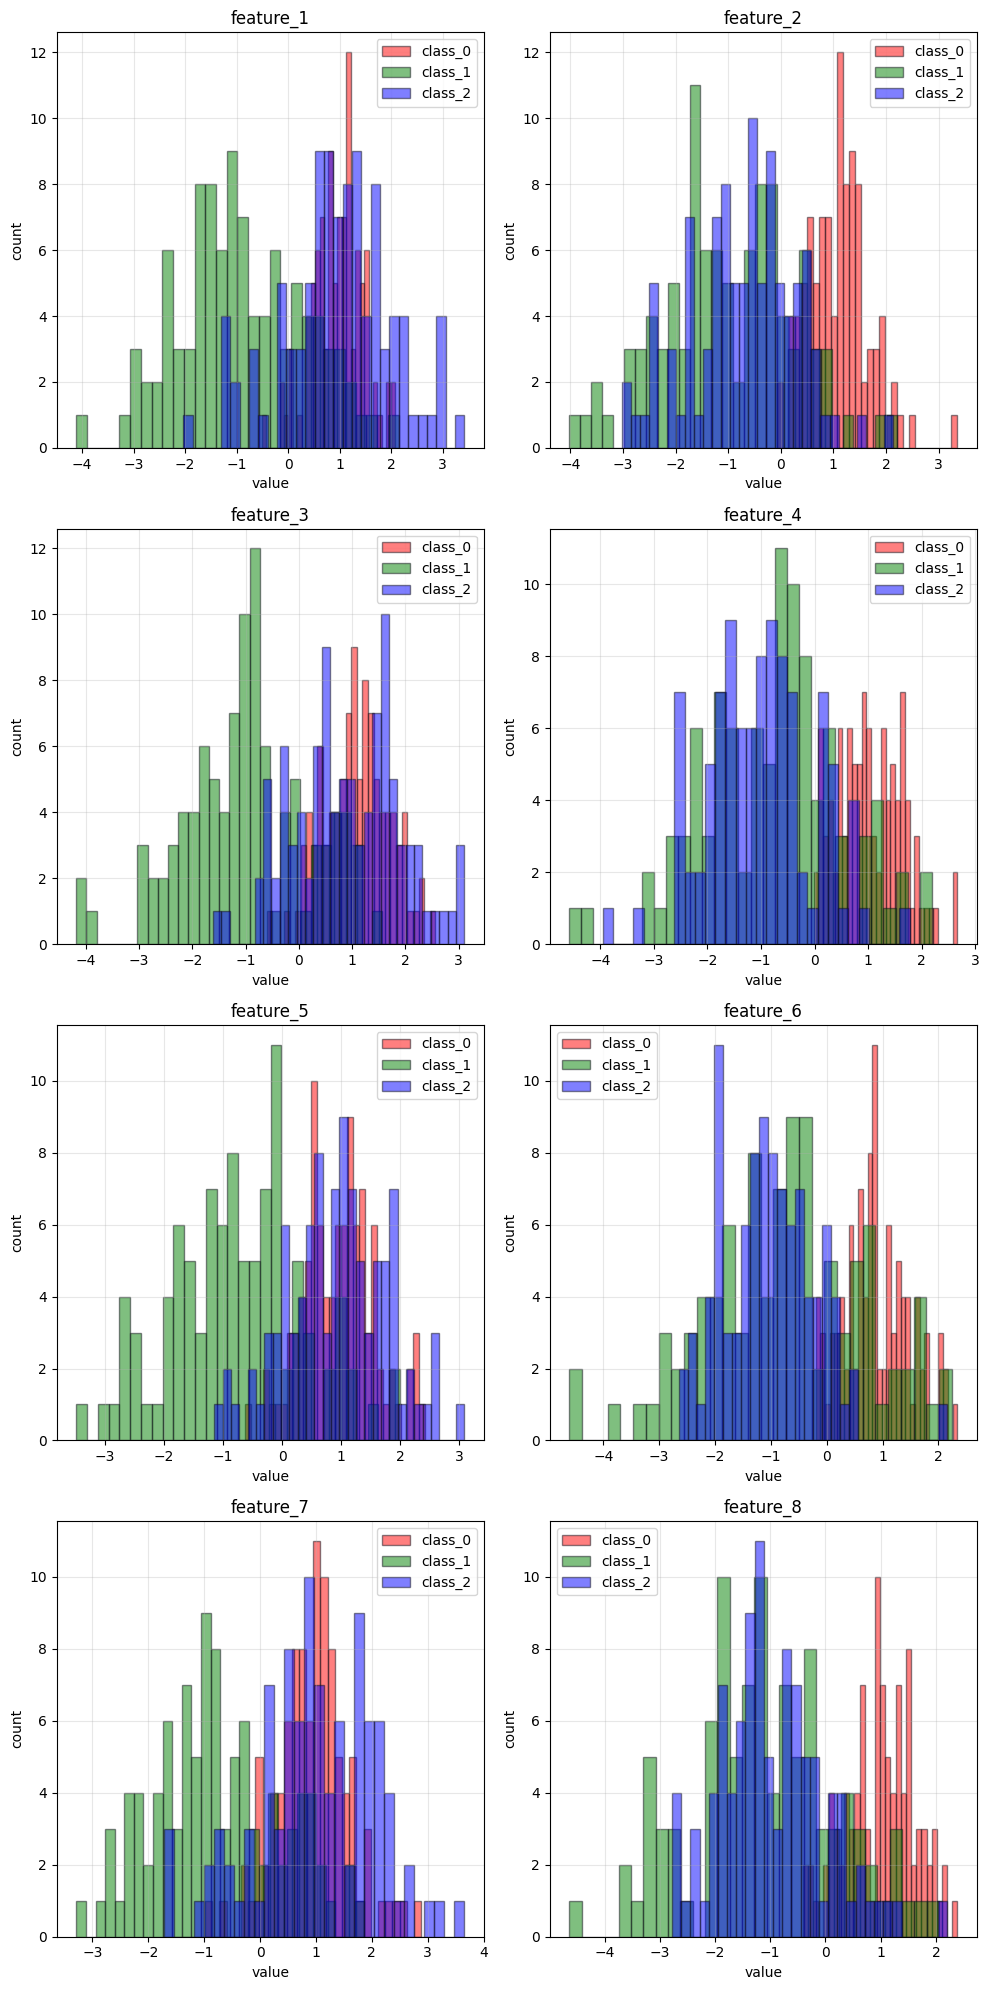

In [36]:
X = df1[COLUMNS]
y = df1["target"]


plotter = Plotter(nrows=4, ncols=2, figsize=(10, 20))

for i, col in enumerate(COLUMNS):
    plotter.set_position(idx=i)

    for class_value in range(n_classes):
        mask = y == class_value
        plotter.hist(
            df1[mask][col],
            bins=30,
            color=COLORS[class_value],
            alpha=0.5,
            edgecolor=EDGECOLOR,
            label=f"class_{class_value}",
        )
    plotter.labels("value", "count", col)
    plotter.grid(True, alpha=0.3)
    plotter.legend()

plotter.tight_layout()
plotter.save(f"{SAVE_DIR}/df1_hists.png", dpi=DPI)

 ##### **_Show grid_**

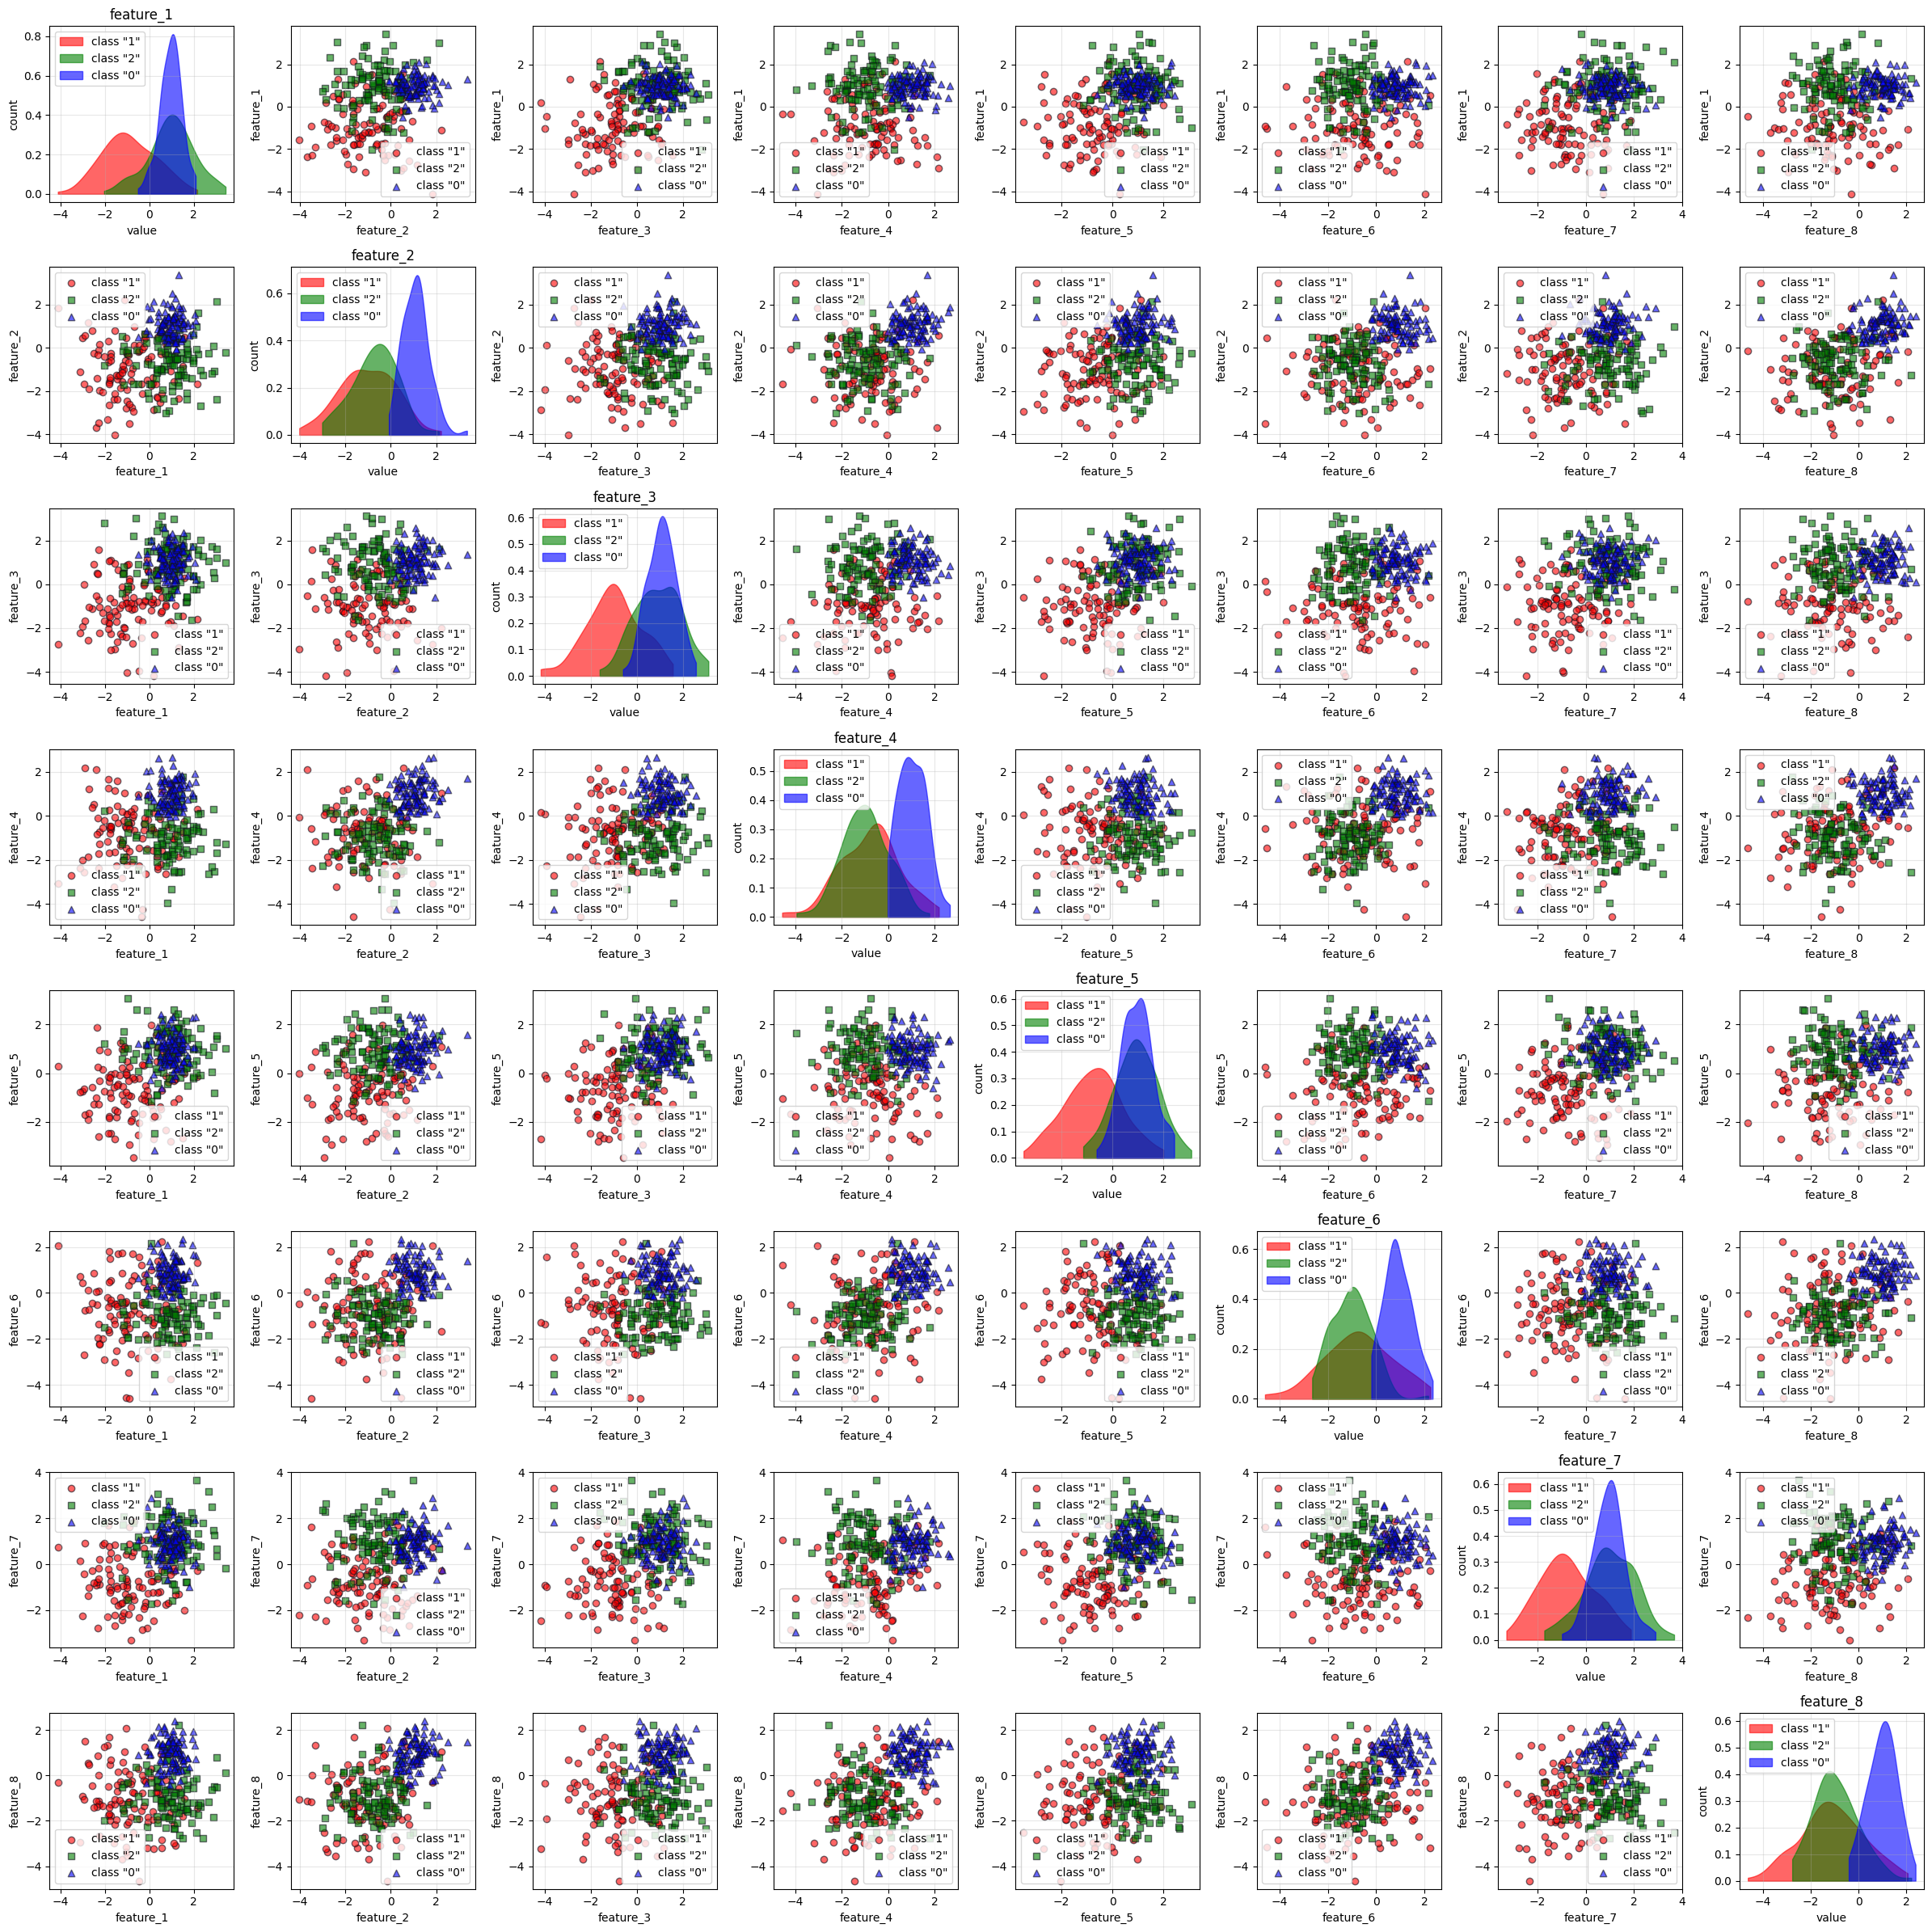

In [37]:
if CALC_GRID:
    plotter = Plotter(nrows=8, ncols=8, figsize=(24, 24))

    plotter.dataset_visual(
        df1[COLUMNS], df1["target"], COLORS, STYLES, EDGECOLOR, alpha=0.6
    )

    plotter.tight_layout()
    plotter.save("res/df1_8x8.png", dpi=200)



 ### **Stage 2 (tasks 2):** _Creating dataframes with emissions_

 ##### **_Calculating logdf's_**

In [38]:
@cached()
def make_AB(df):
    data = {"df": df}

    target_class = 0

    for a in [1, 10, 100]:
        for b in [1, 10, 100]:
            new_vals = {"target": [target_class] * a}
            t = -1
            for f in COLUMNS:
                new_vals[f] = [t * b] * a
                t *= -1

            new_obj = pd.DataFrame(new_vals)
            new_df = pd.concat([df, new_obj], ignore_index=True)
            
            data[f"df_{a}_{b}"] = new_df
    
    return data


data = make_AB(df1)

> Calculating result for make_AB...


In [39]:
def filter_data(df, classes, features):
    classes_remap = {classes[0]: 0, classes[1]: 1}
    df_filtered = df[df["target"].isin(classes)].copy()
    df_filtered["target"] = df_filtered["target"].map(classes_remap)
    X, y = df_filtered[features].values, df_filtered["target"].values

    return df_filtered, X, y

 ### **Stage 3 (task 3):** _Linear and Log Regressions for datasets_

 ##### **_Model training and ROC_CI calculations_**

In [40]:
@cached()
def calc_aucroc_with_ci(y_true, y_pred_proba, n_bootstraps=1000, confidence_level=0.95):
    n_samples = len(y_true)
    auc_scores = []
    mean_fpr = np.linspace(0, 1, 100)
    fpr_list = []
    tpr_list = []

    origin_fpr, origin_tpr, _ = roc_curve(y_true, y_pred_proba)
    origin_auc = auc(origin_fpr, origin_tpr)
    
    for i in tqdm.tqdm(range(n_bootstraps)):
        indices = np.random.choice(range(n_samples), size=n_samples, replace=True)
        
        if len(np.unique(y_true[indices])) < 2:
            continue
            
        fpr, tpr, _ = roc_curve(y_true[indices], y_pred_proba[indices])
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        fpr_list.append(mean_fpr)
        tpr_list.append(tpr_interp)
        bootstrap_auc = auc(fpr, tpr)
        auc_scores.append(bootstrap_auc)
    
    alpha = (1 - confidence_level) / 2
    tpr_lower = np.percentile(tpr_list, 100 * alpha, axis=0)
    tpr_upper = np.percentile(tpr_list, 100 * (1 - alpha), axis=0)
    ci_lower = np.percentile(auc_scores, 100 * alpha)
    ci_upper = np.percentile(auc_scores, 100 * (1 - alpha))
    
    mean_tpr = np.mean(np.array(tpr_list), axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    
    return origin_fpr, origin_tpr, origin_auc, mean_fpr, ci_lower, tpr_lower, ci_upper, tpr_upper, mean_tpr, mean_auc


def draw_curve(plotter, title, rx, ry, o_fpr, o_tpr, o_auc, m_fpr, l_auc, l_tpr, u_auc, u_tpr, m_tpr, m_auc, confidence_level=0.95, threshold=0.5):
    plotter.plot(o_fpr, o_tpr, color="green", alpha=0.7, label=f"origin ROC curve ({o_auc:.4f})")
    plotter.plot(m_fpr, m_tpr, color="blue", alpha=0.7, label=f"mean ROC curve {m_auc:.4f}")
    plotter.fill_between(m_fpr, l_tpr, u_tpr, color="#25eab6", alpha=0.3, label=f"CI{int(confidence_level * 100)}%\nmin_auc={l_auc:.4f}\nmax_auc={u_auc:.4f}")
    plotter.plot([0, 1], [0, 1], color="red", linestyle="--", alpha=0.6, label="Baseline")
    plotter.scatter([rx], [ry], color="red", s=30, label=f"Classification point for threshold {threshold:.2f}")
    plotter.labels("fpr", "tpr", title)
    plotter.grid(True, alpha=0.3)
    plotter.legend()
    

def decision_roc_point(pred, truth, threshold):
    pred_binary = np.where(pred >= threshold, 1, 0)
    
    TP = np.sum((pred_binary == 1) & (truth == 1))
    FP = np.sum((pred_binary == 1) & (truth == 0))
    
    P = np.sum(truth == 1)
    N = np.sum(truth == 0)
    
    TPR = TP / P if P > 0 else 0
    FPR = FP / N if N > 0 else 0
    
    return FPR, TPR

 ##### **_Main function for tasks 3, 4, 5_**

In [41]:
def make_models_and_plots(data, classes, feature, threshold=0.5, confidence_level=0.95):
    nrows = 1
    ncols = 2

    plotters = [Plotter(nrows=nrows, ncols=ncols, figsize=(18, 8)) for _ in range(len(data.keys()))]

    for i, dataset in enumerate(data.keys()):
        plotter = plotters[i]

        _, lX, ly = filter_data(data[dataset], classes, [feature])

        class0_mask = ly == 0
        class1_mask = ly == 1

        lin_reg = LinearRegression()
        lin_reg.fit(lX.reshape(-1, 1), ly)
        log_reg = LogisticRegression()
        log_reg.fit(lX, ly)
        
        k_log = log_reg.coef_.flatten()
        b_log = log_reg.intercept_

        k_lin = lin_reg.coef_.flatten()
        b_lin = lin_reg.intercept_

        lin_reg_v = np.log(1 / threshold - 1)
        x_log_decision = ((lin_reg_v + b_log) / -k_log)[0]
        
        log_prediction = log_reg.predict_proba(lX)[:, 1]
        # lin_prediction = lin_reg.predict(lX.reshape(-1, 1))

        plotter.set_position(idx=0)
        
        X_sigmoid = np.linspace(lX.min(), lX.max(), 100)
        Y_sigmoid = log_reg.predict_proba(X_sigmoid.reshape(-1, 1))[:, 1]

        X_linear = np.array([-b_lin / k_lin, (1 - b_lin) / k_lin])
        Y_linear = lin_reg.predict(X_linear.reshape(-1, 1))

        plotter.axhline(y=threshold, color="red", linestyle="--", alpha=0.7, label=f"Threshold={float(threshold):.6f}")
        plotter.axvline(x=x_log_decision, color="#f58c0c", linestyle="--", alpha=0.7, label=f"Threshold X={float(x_log_decision):.6f}")
        plotter.plot(X_sigmoid, Y_sigmoid, c="b", alpha=0.7, label="Logistic Regression")
        plotter.plot(X_linear, Y_linear, color="#126662", alpha=0.7, label="Linear Regression")
        plotter.scatter(
            lX.flatten(),
            log_reg.predict_proba(lX.reshape(-1, 1))[:, 1],
            c=ly,
            s=20,
            marker="*",
            cmap="RdYlGn",
        )
        plotter.scatter(
            lX[class0_mask],
            ly[class0_mask],
            c="red",
            edgecolor=EDGECOLOR,
            alpha=0.6,
            label="Class 0"
        )
        plotter.scatter(
            lX[class1_mask],
            ly[class1_mask],
            c="green",
            edgecolor=EDGECOLOR,
            alpha=0.6,
            label="Class 1"
        )
        plotter.labels(feature, "class", f"{dataset}")
        plotter.grid(True, alpha=0.3)
        plotter.legend()
        

        plotter.set_position(idx=1)
        
        rx, ry = decision_roc_point(log_prediction, ly, threshold)
        draw_curve(plotter, "Logistic Regression ROC", rx, ry,
                   *calc_aucroc_with_ci(ly, log_prediction, confidence_level=confidence_level),
                   confidence_level=confidence_level,
                   threshold=threshold)

        '''
        plotter.set_position(idx=2)
        
        rx, ry = decision_roc_point(lin_prediction, ly, threshold)
        draw_curve(plotter, "Linear Regression ROC", rx, ry, 
                   *calc_aucroc_with_ci(ly, lin_prediction, confidence_level=confidence_level),
                   confidence_level=confidence_level,
                   threshold=threshold)
        '''
    
    return plotters



 ##### **_Task 3_**

> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1810.58it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1753.67it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1802.77it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1792.40it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1618.39it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1801.15it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1794.47it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1730.31it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1606.33it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1778.30it/s]


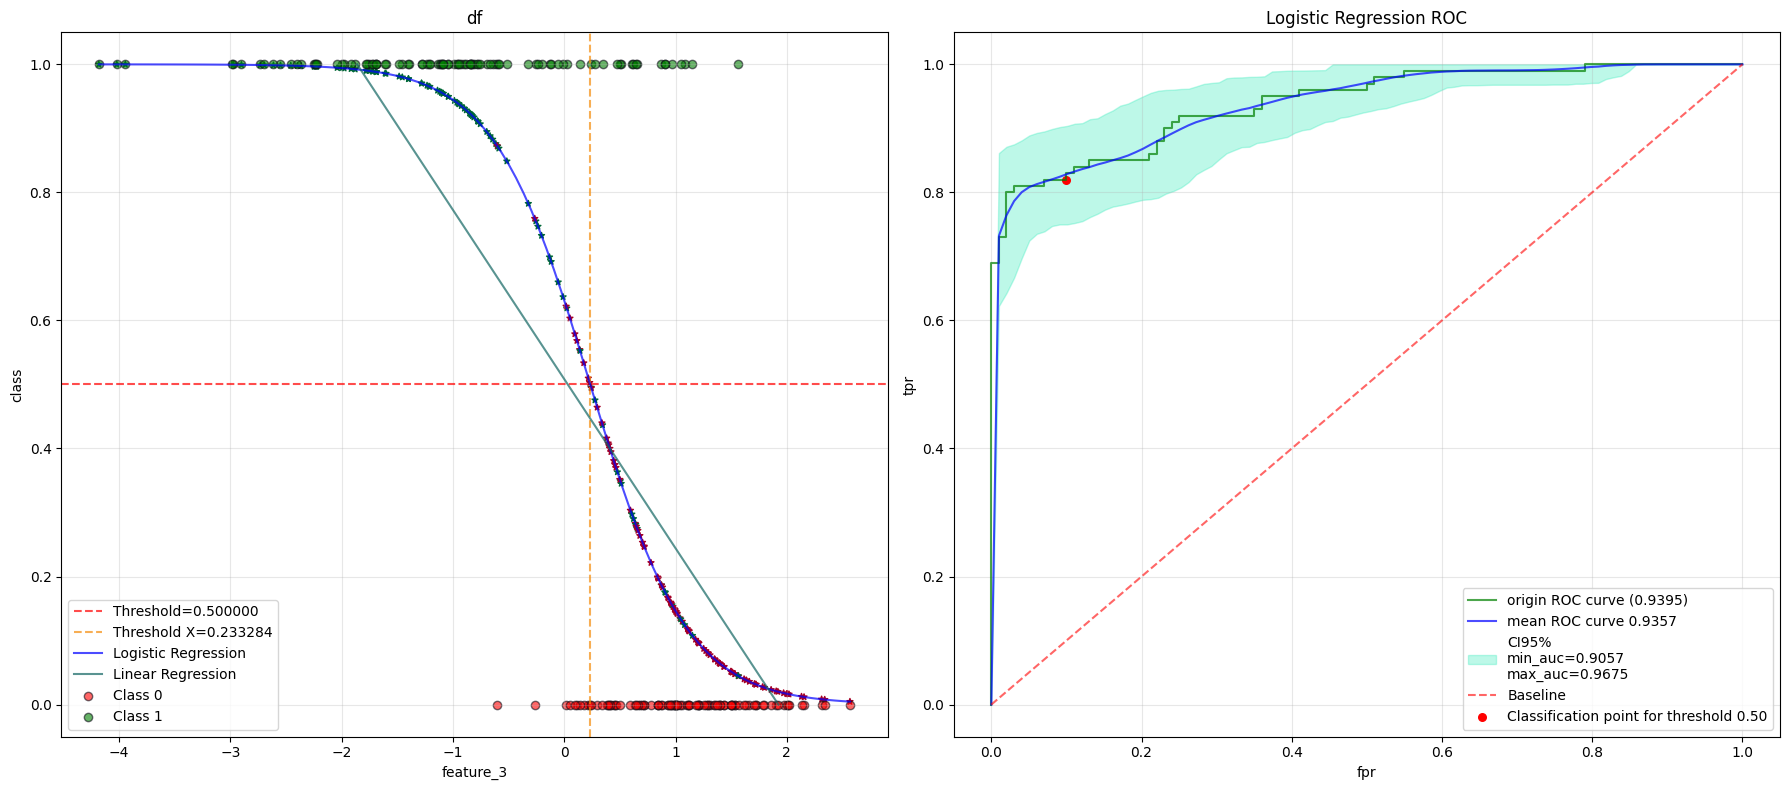

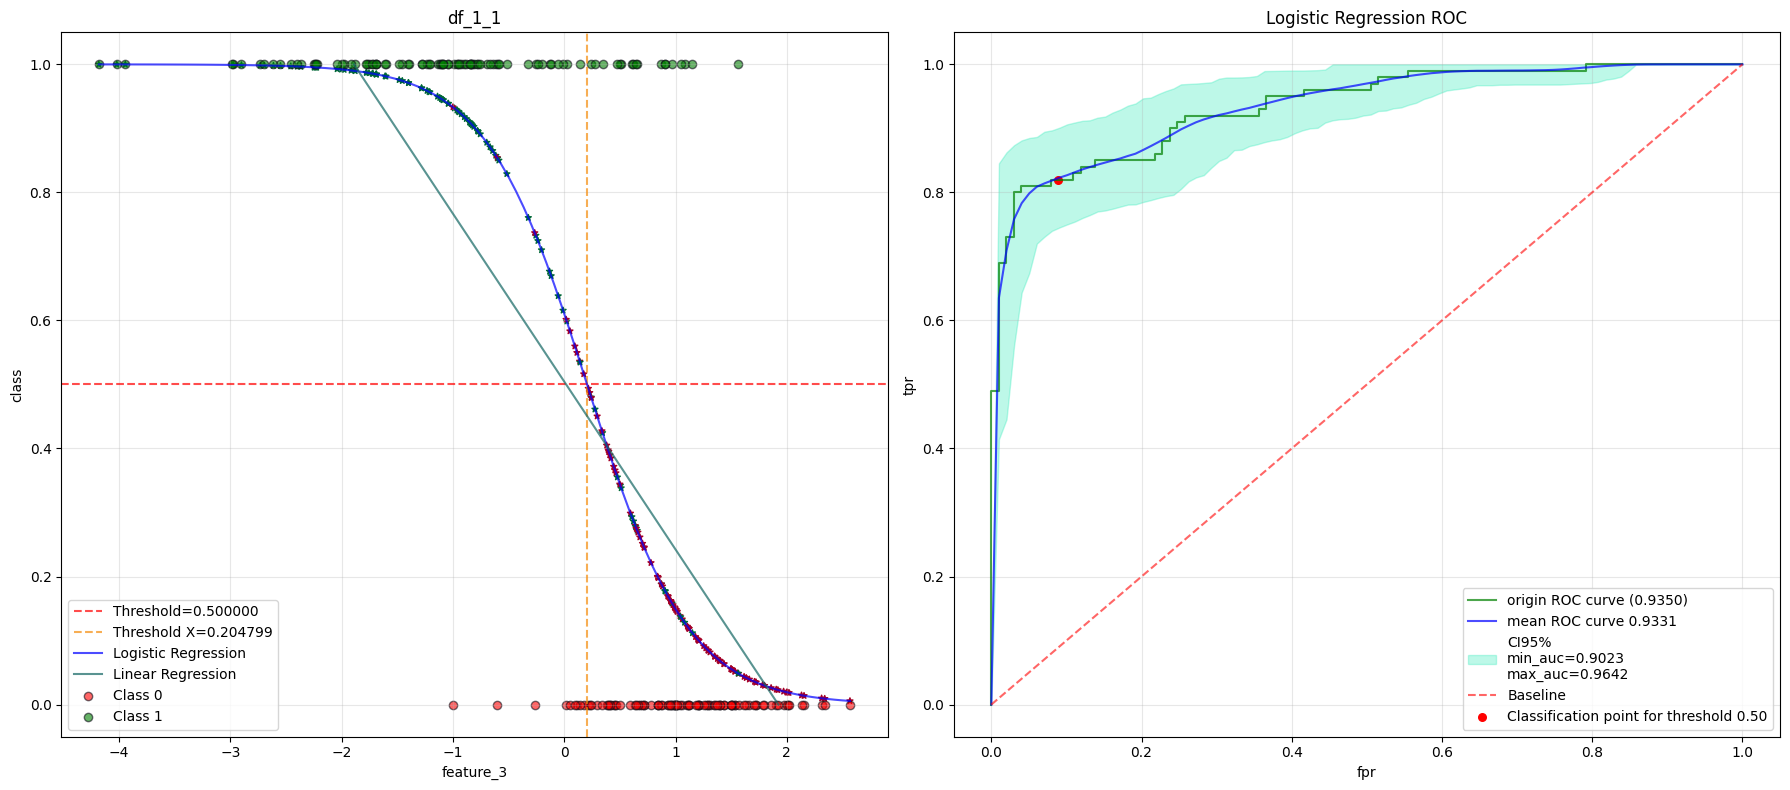

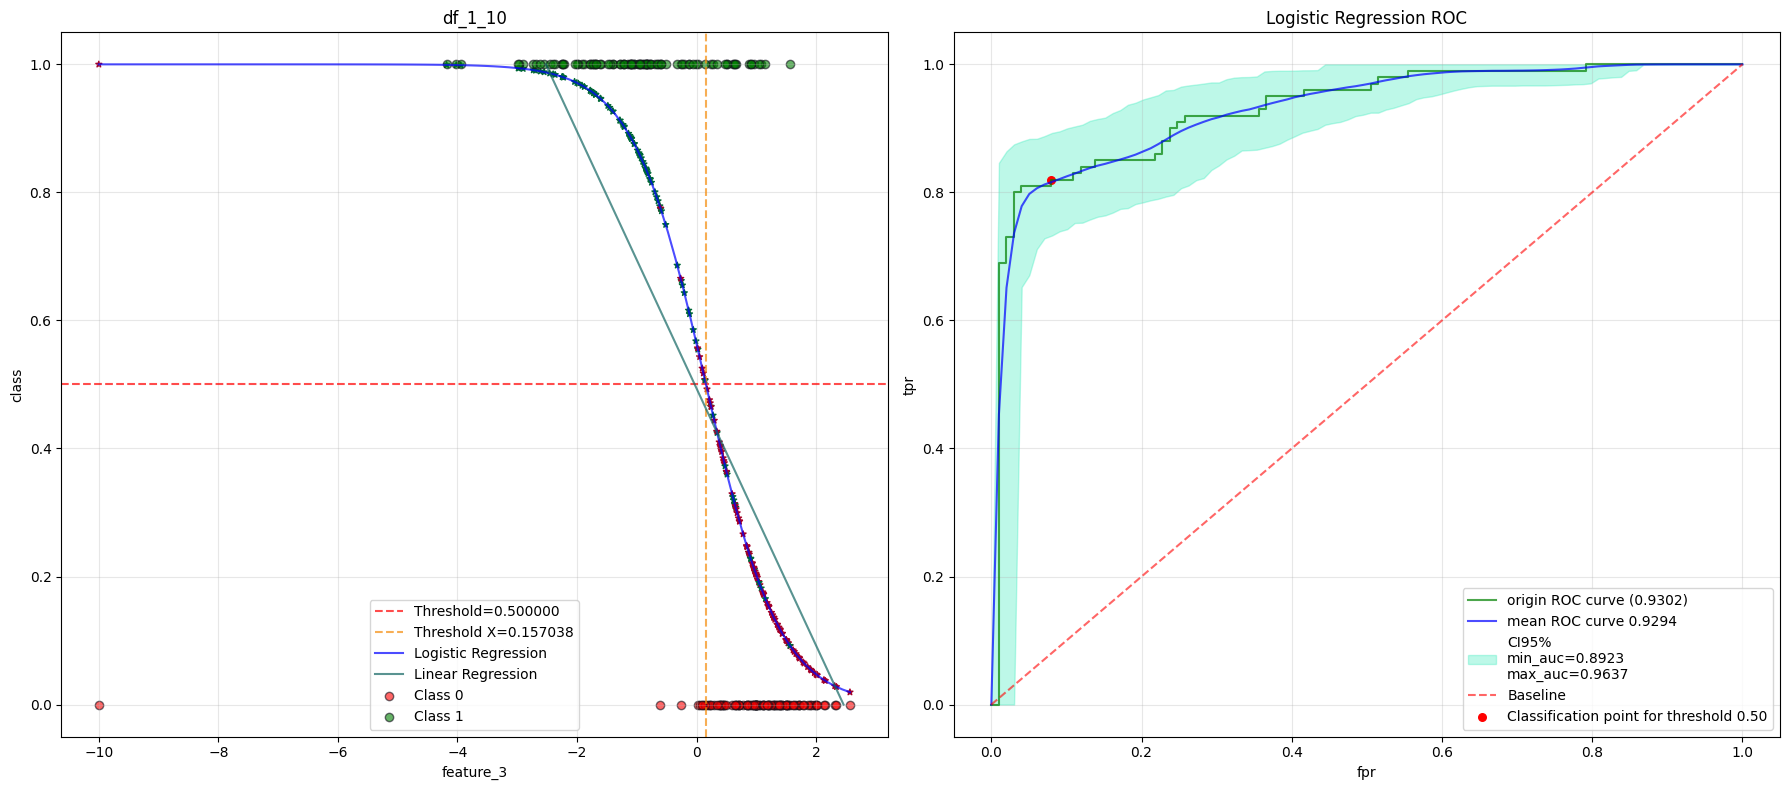

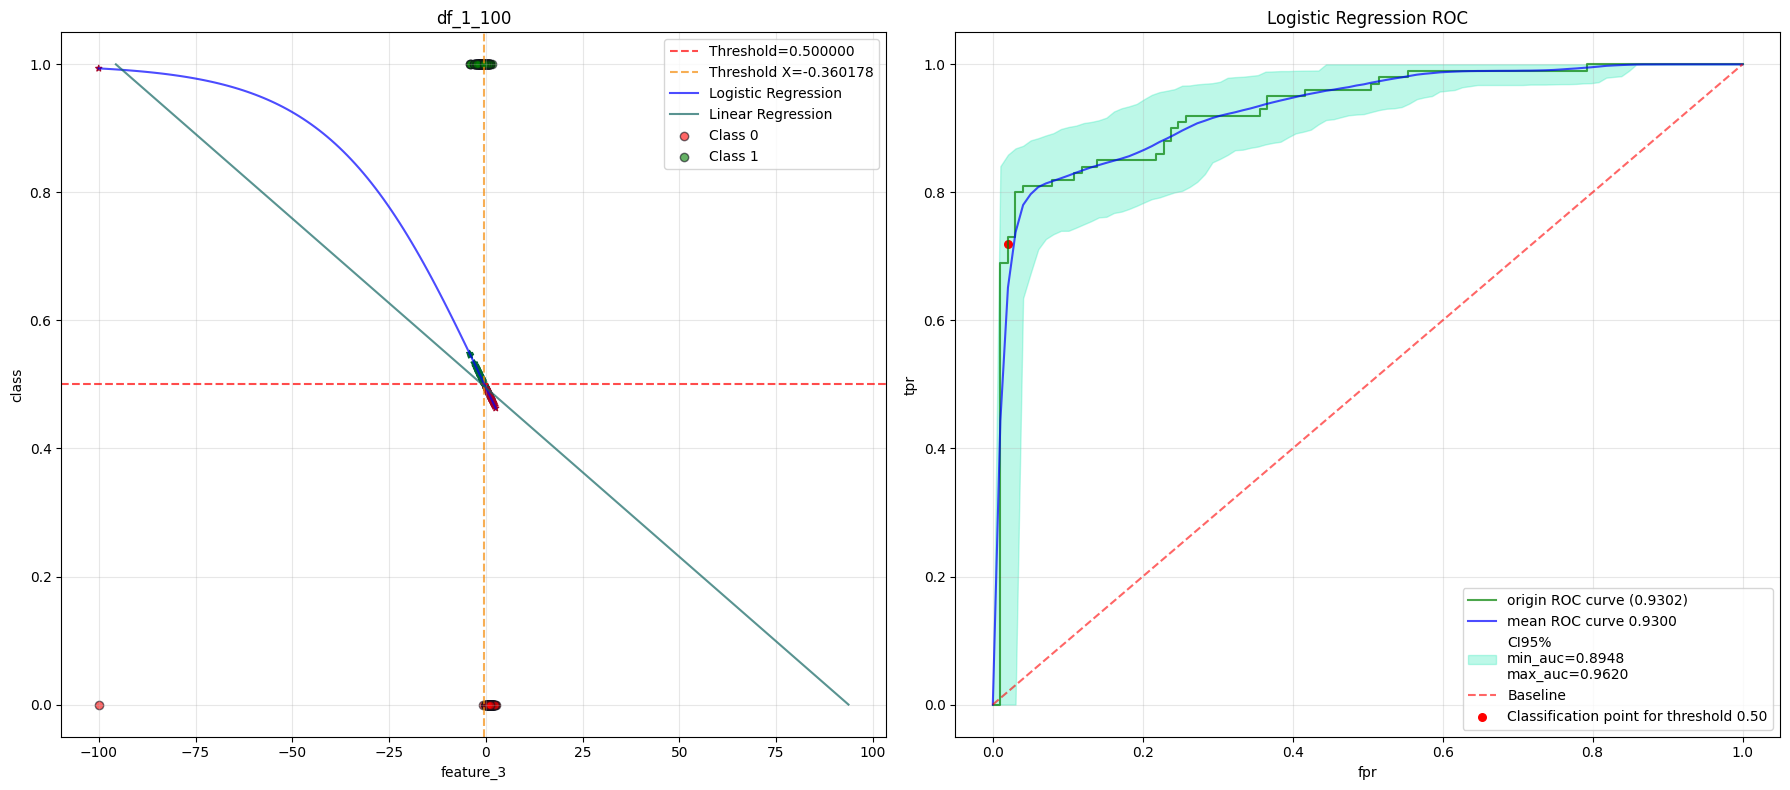

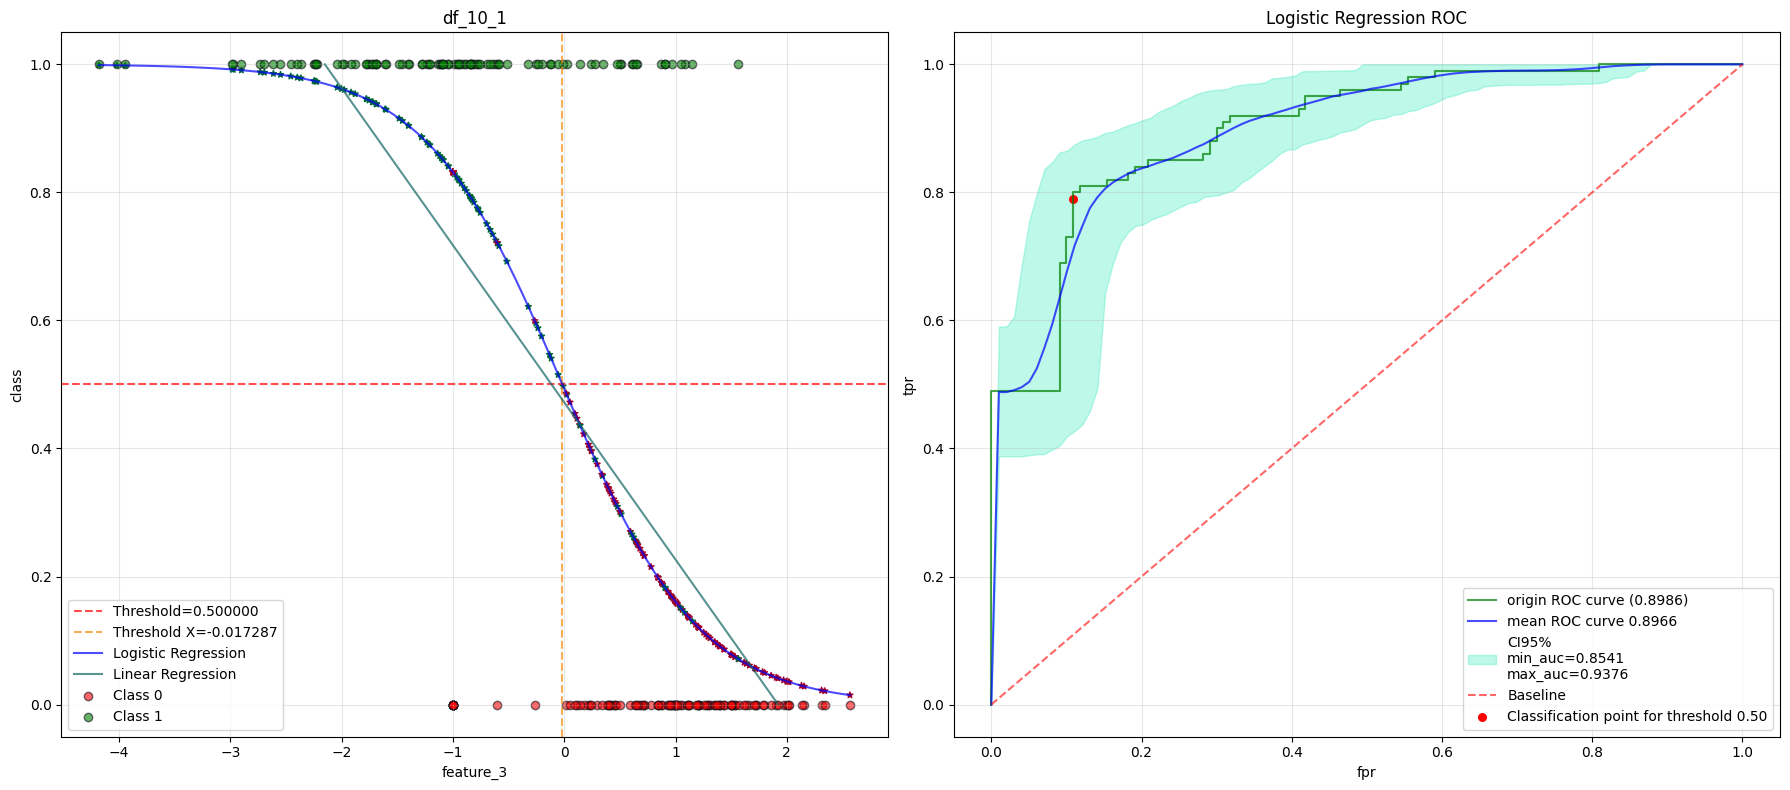

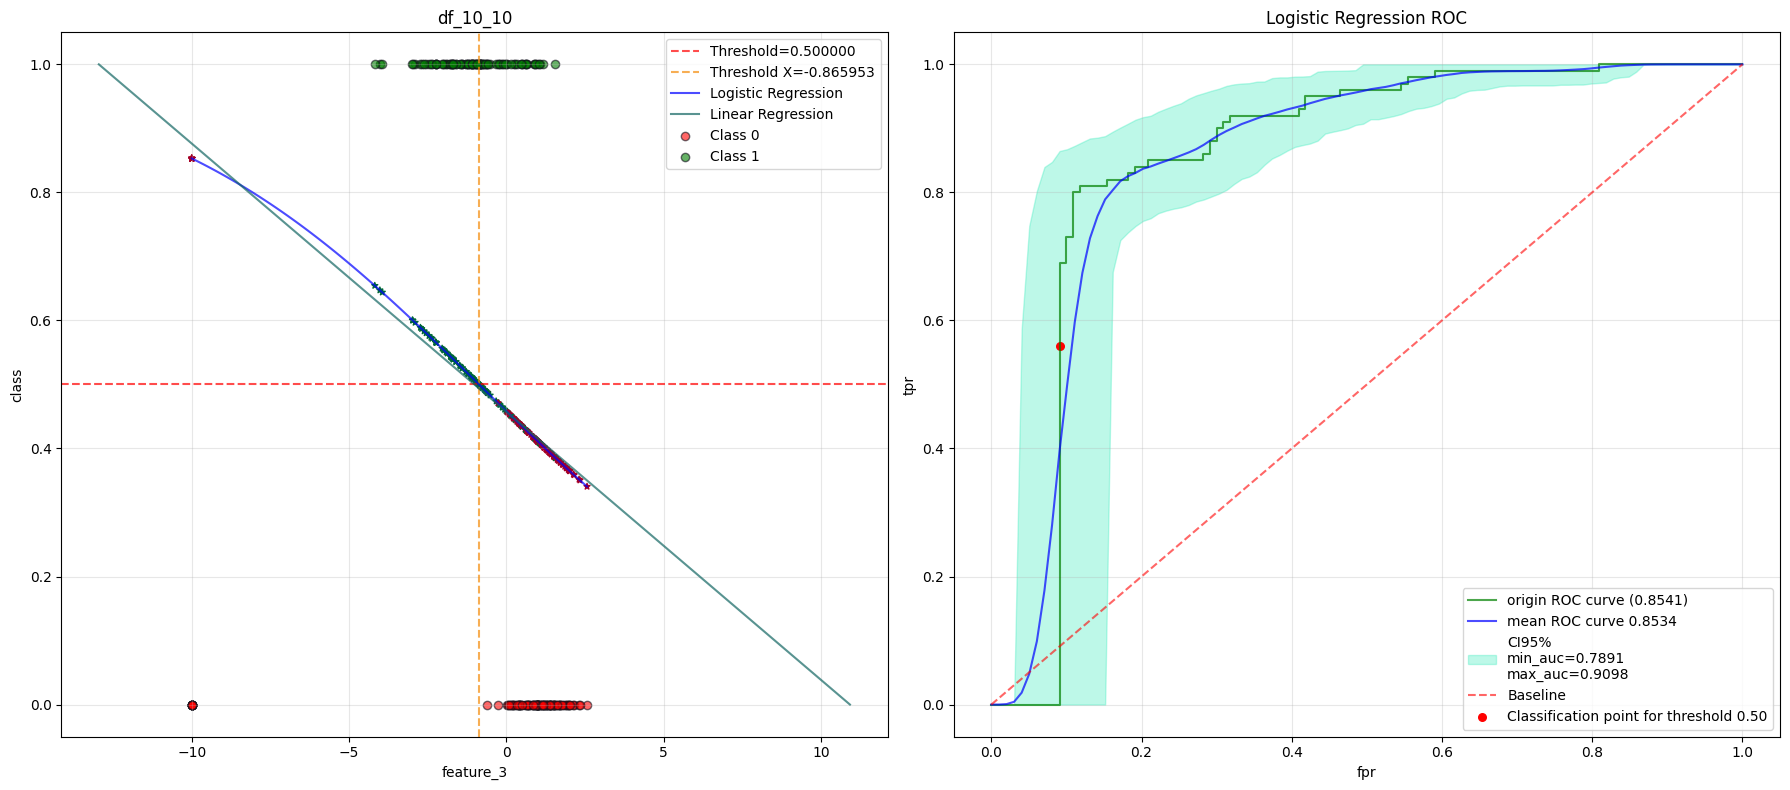

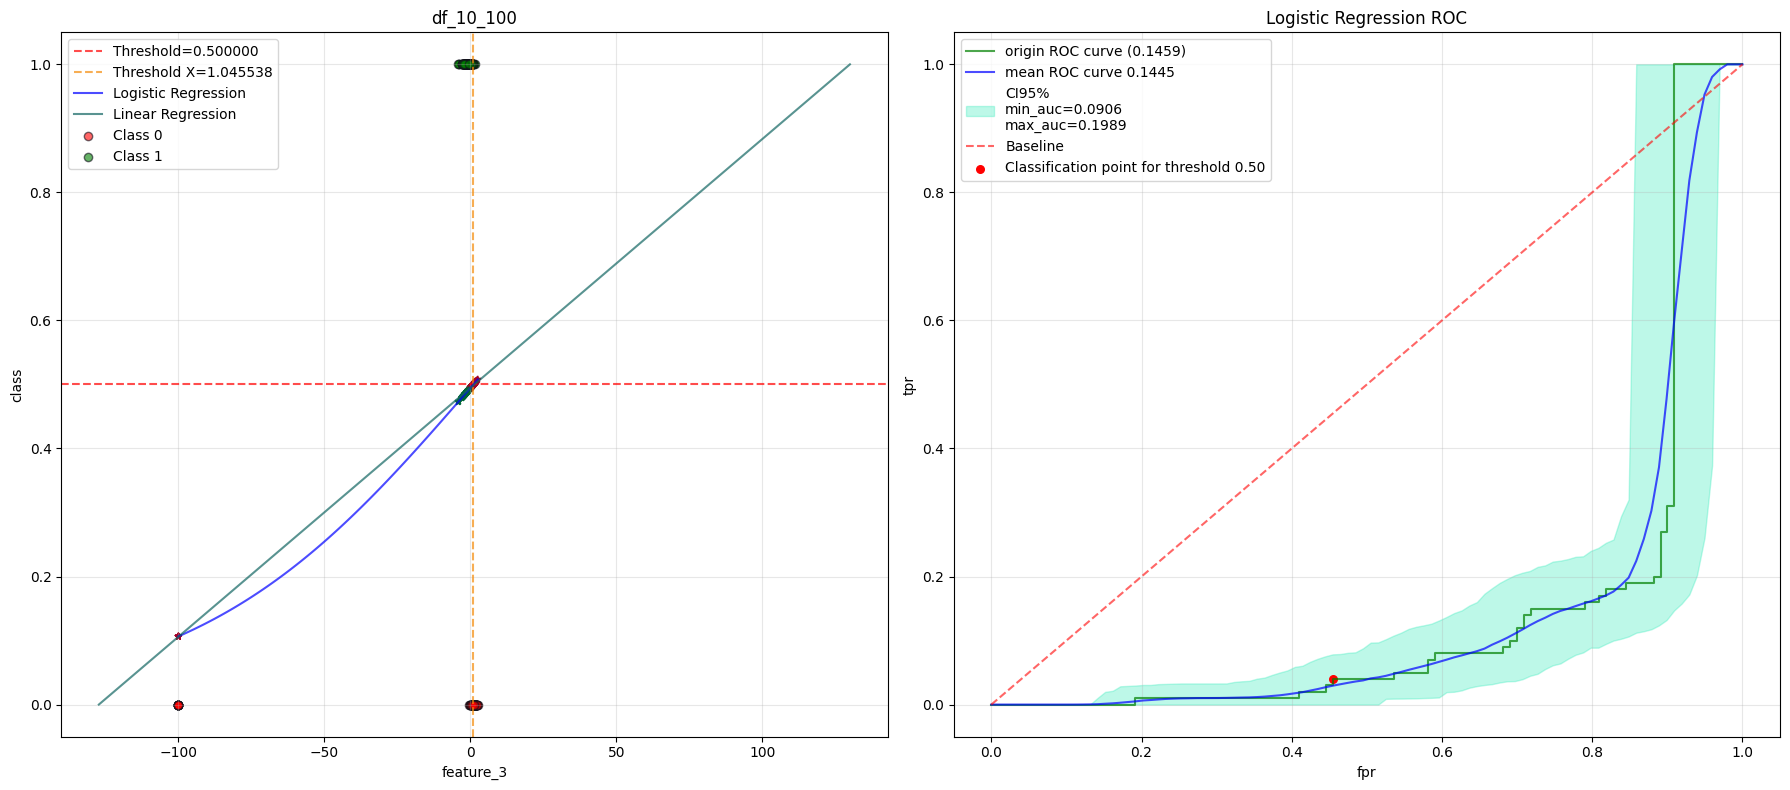

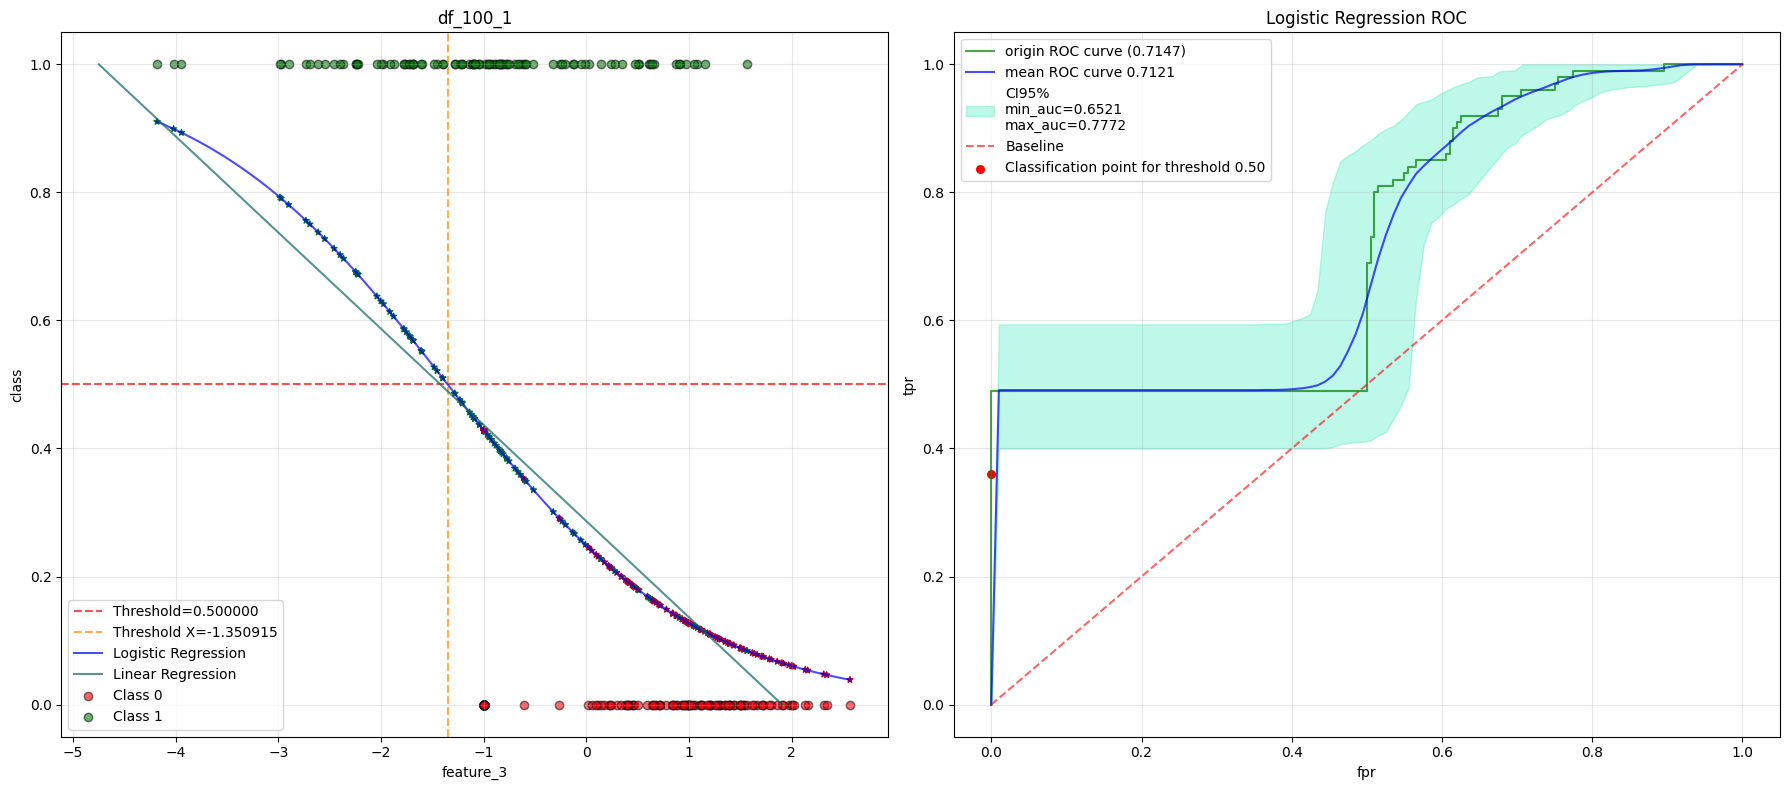

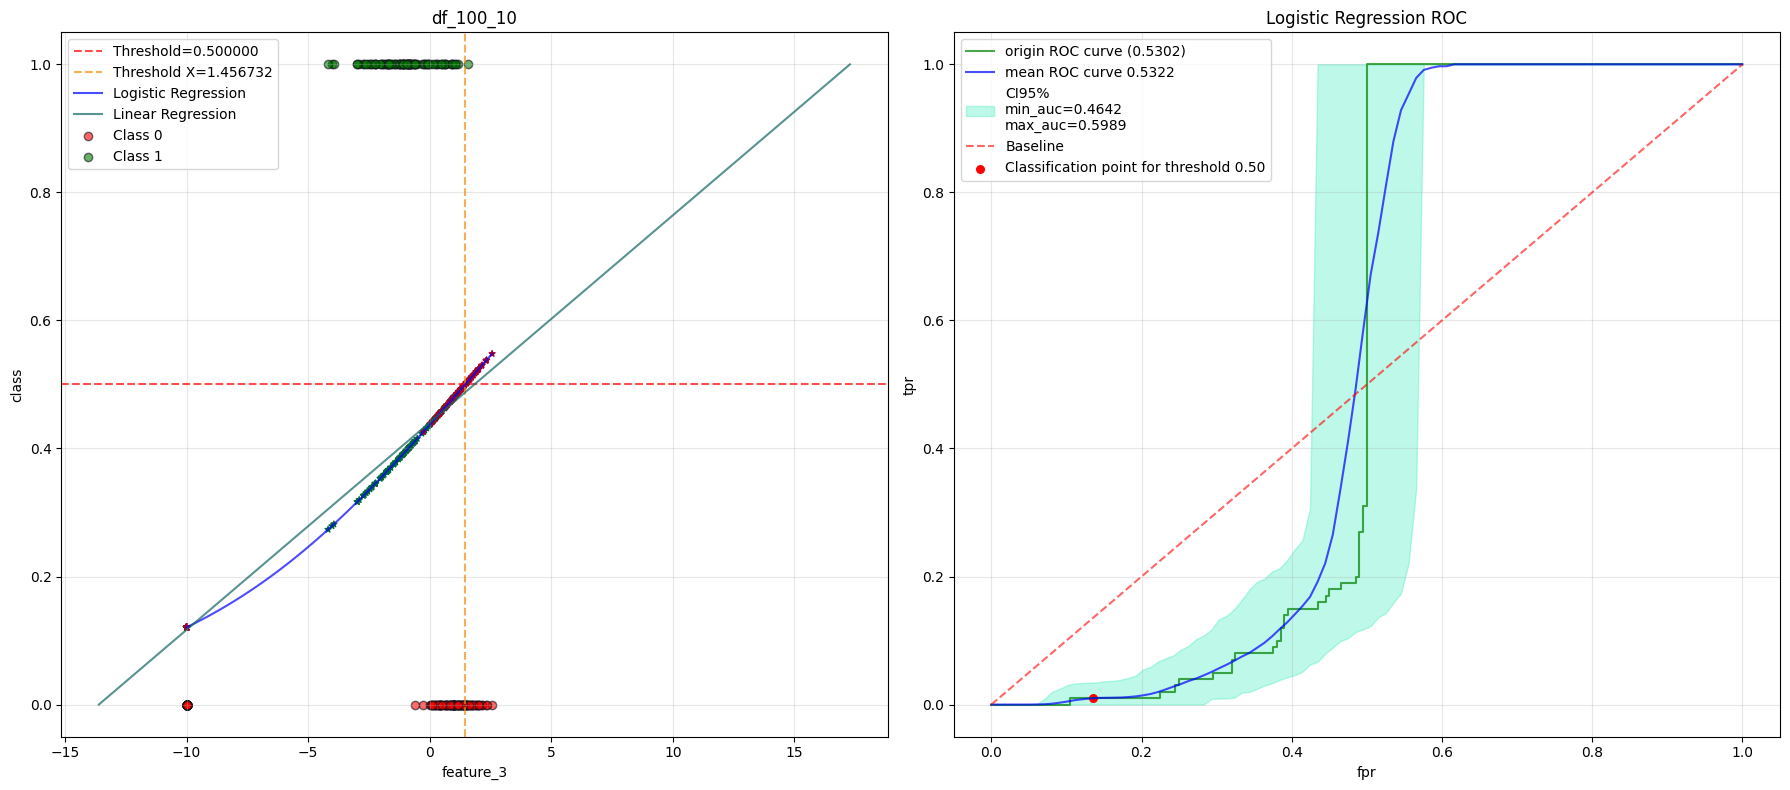

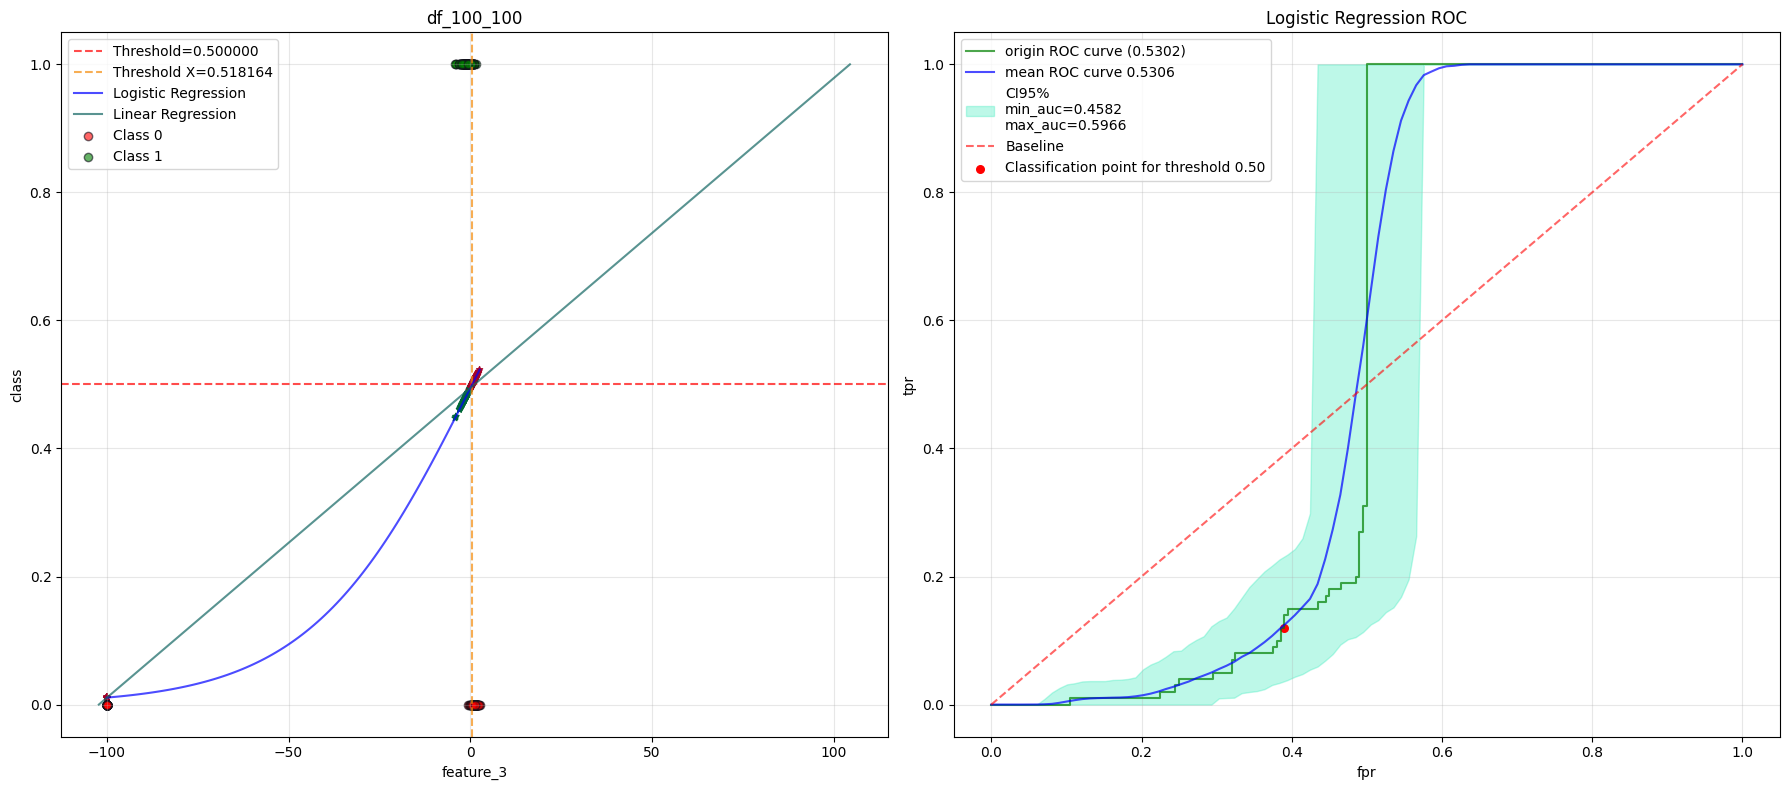

In [51]:
if CALC_T3:
    classes = [0, 1]
    feature = COLUMNS[3]

    plotters = make_models_and_plots(data, classes, feature)

    for i, plotter in enumerate(plotters):
        plotter.tight_layout()
        plotter.save(f"{SAVE_DIR}/linreg_{i}.png")
    


 ### **Stage 4 (tasks [4] [5]):** _Linear and Log Regressions for datasets after linear regression transformation_

In [ ]:
@cached()
def create_log_data(old_data, classes, features):
    logdata = {}

    for dataset in old_data.keys():
        _, lX, ly = filter_data(old_data[dataset], classes, features)
        
        lin_reg = LinearRegression()
        lin_reg.fit(lX, ly)
        
        pred = lin_reg.predict(lX)
        logdata[f"log{dataset}"] = pd.DataFrame({"feature": pred, "target": ly})
    
    return logdata

 ##### **_Task3_**

> Calculating result for create_log_data...
> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1215.47it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1144.84it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1081.98it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1256.15it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1537.18it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1540.17it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1644.79it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1574.43it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1534.79it/s]


> Calculating result for calc_aucroc_with_ci...


100%|██████████| 1000/1000 [00:00<00:00, 1609.29it/s]


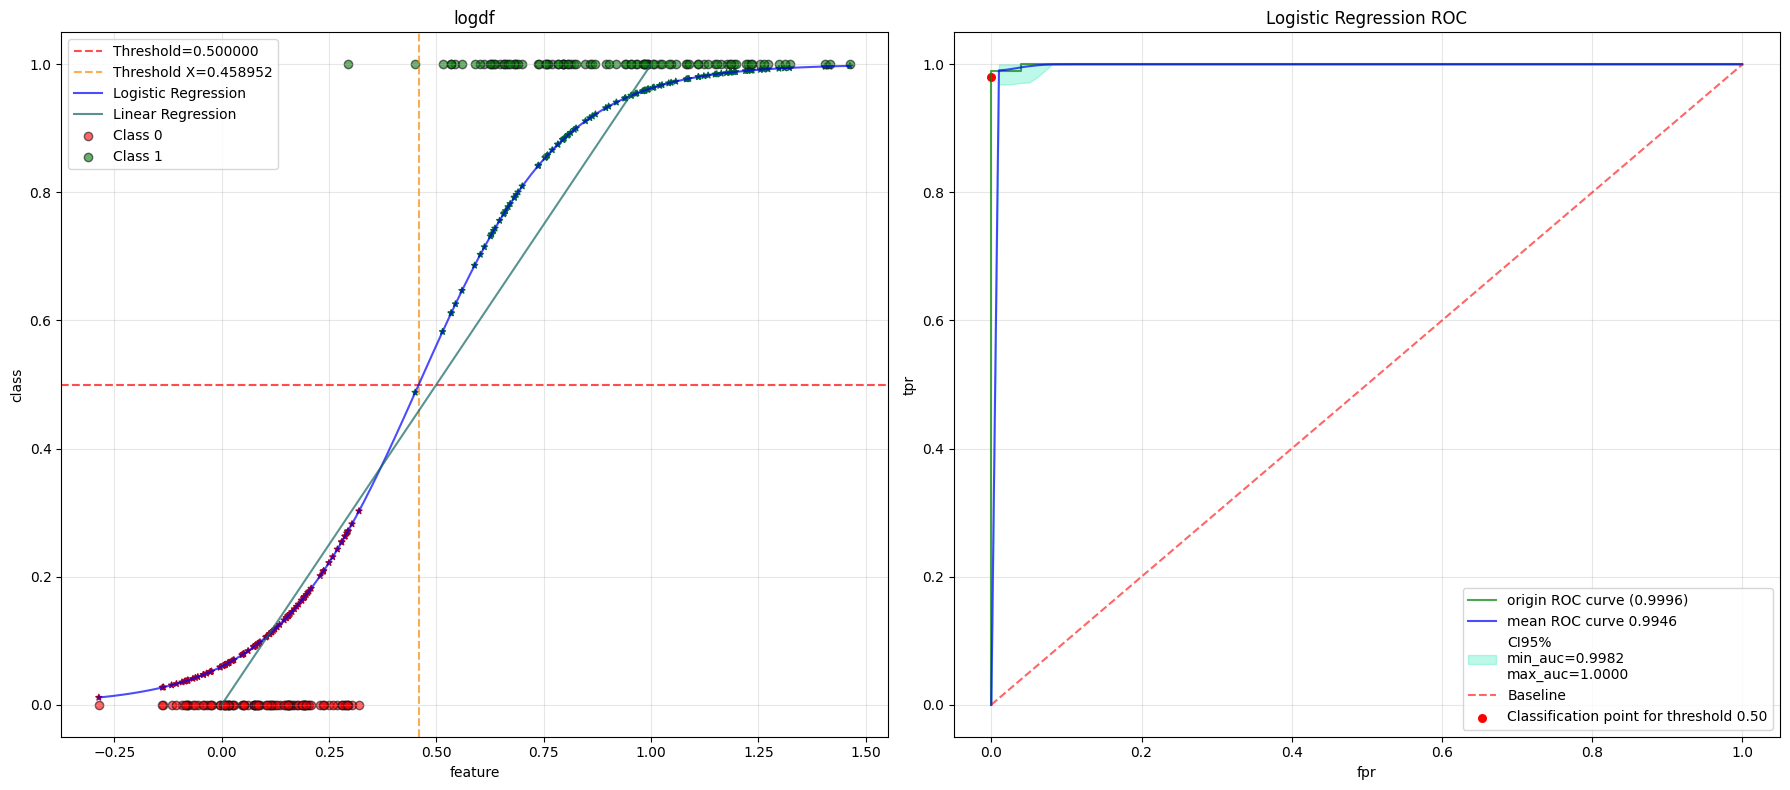

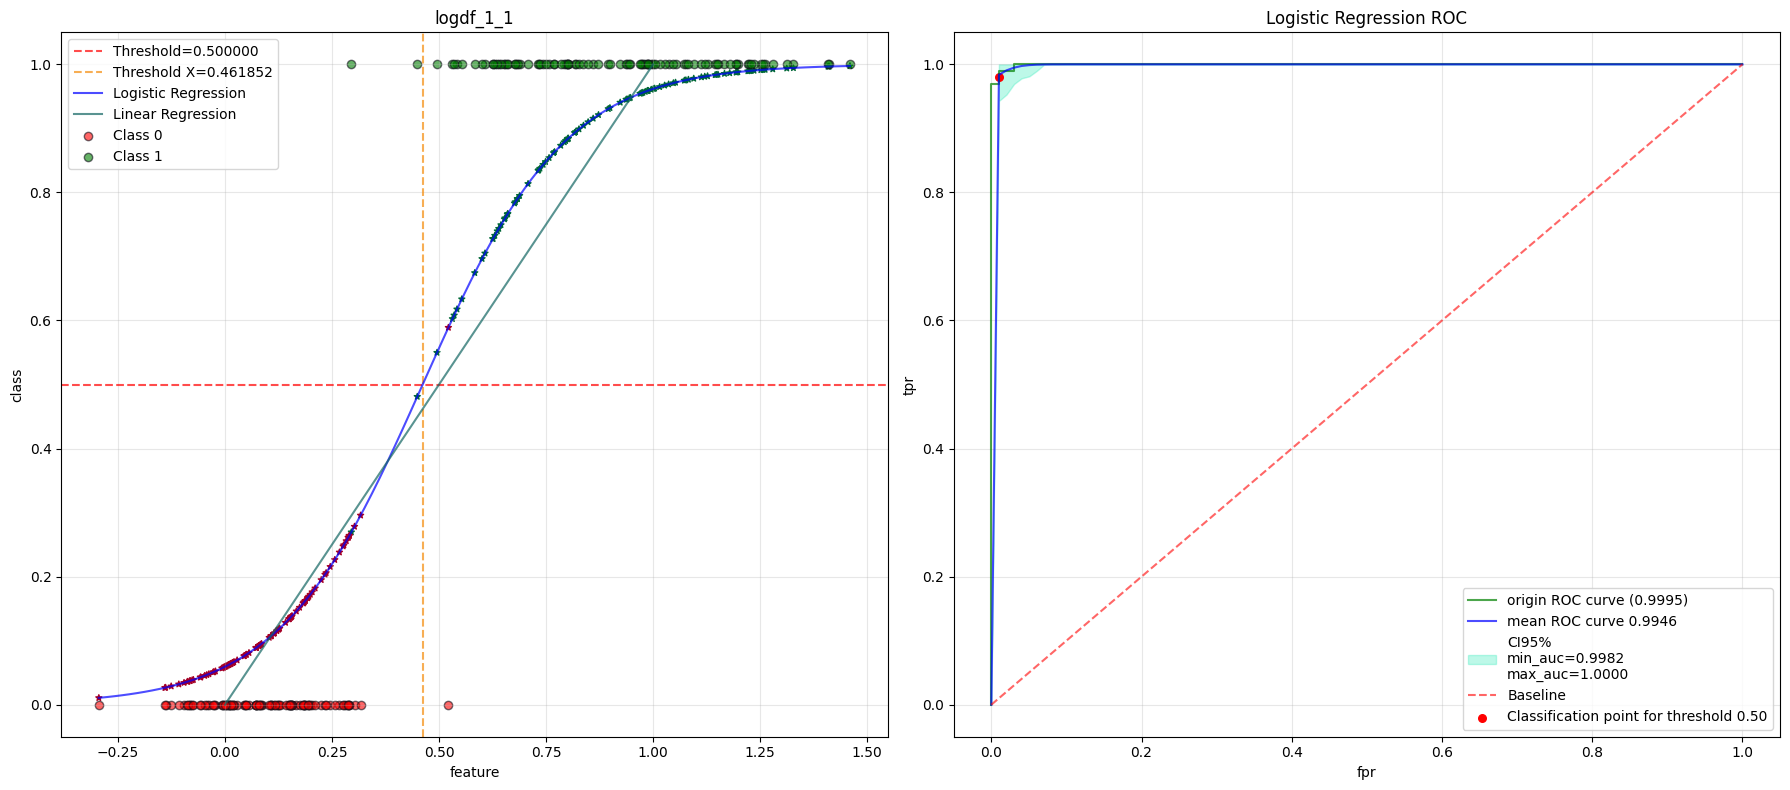

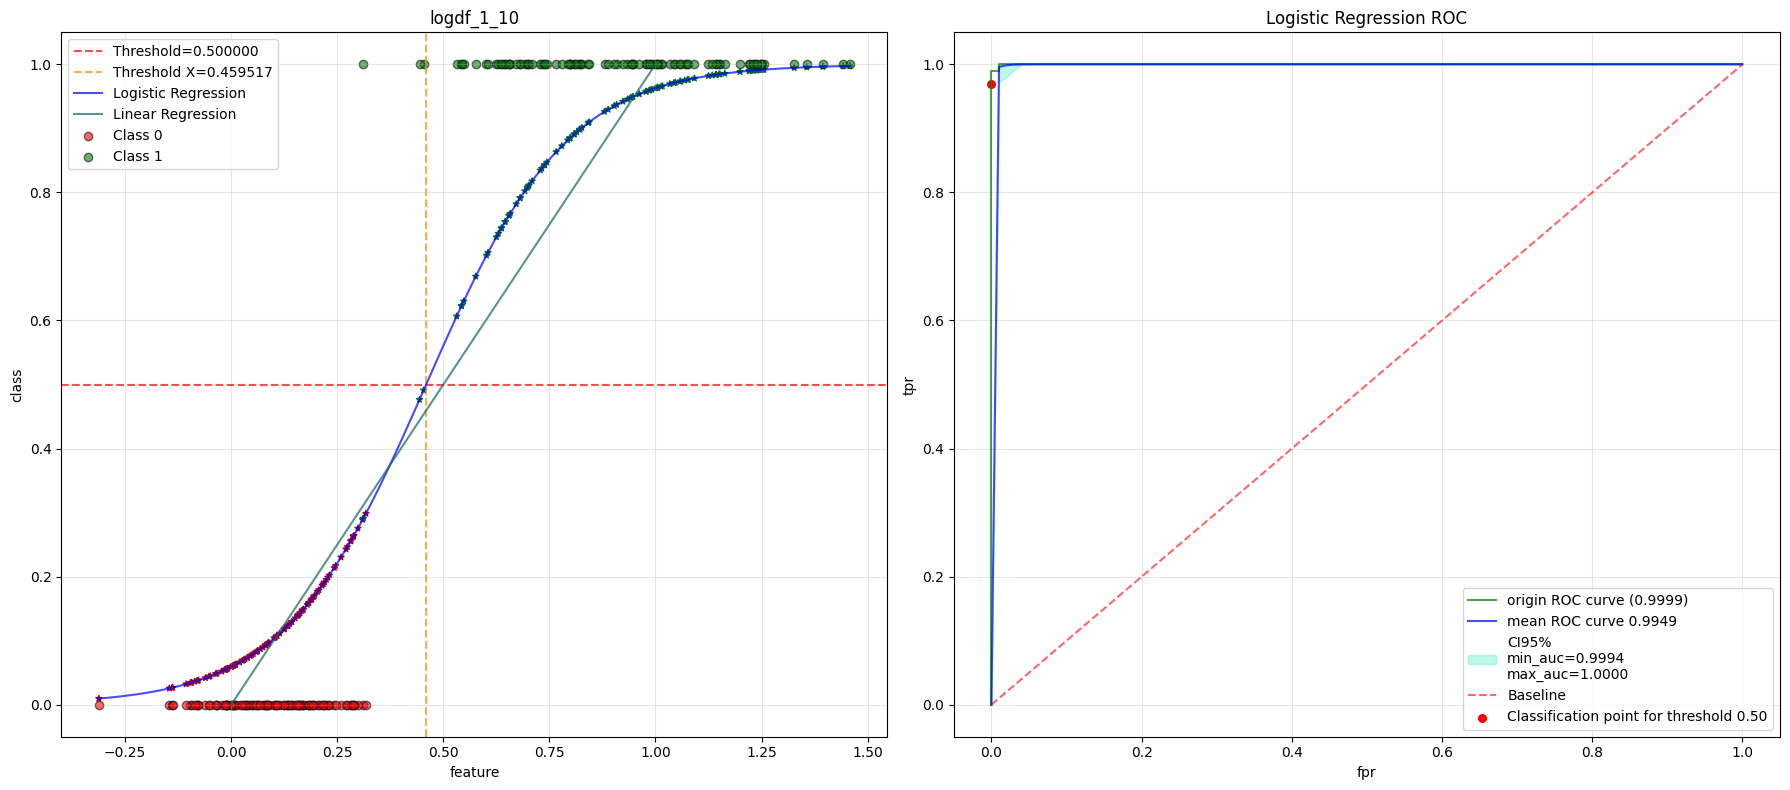

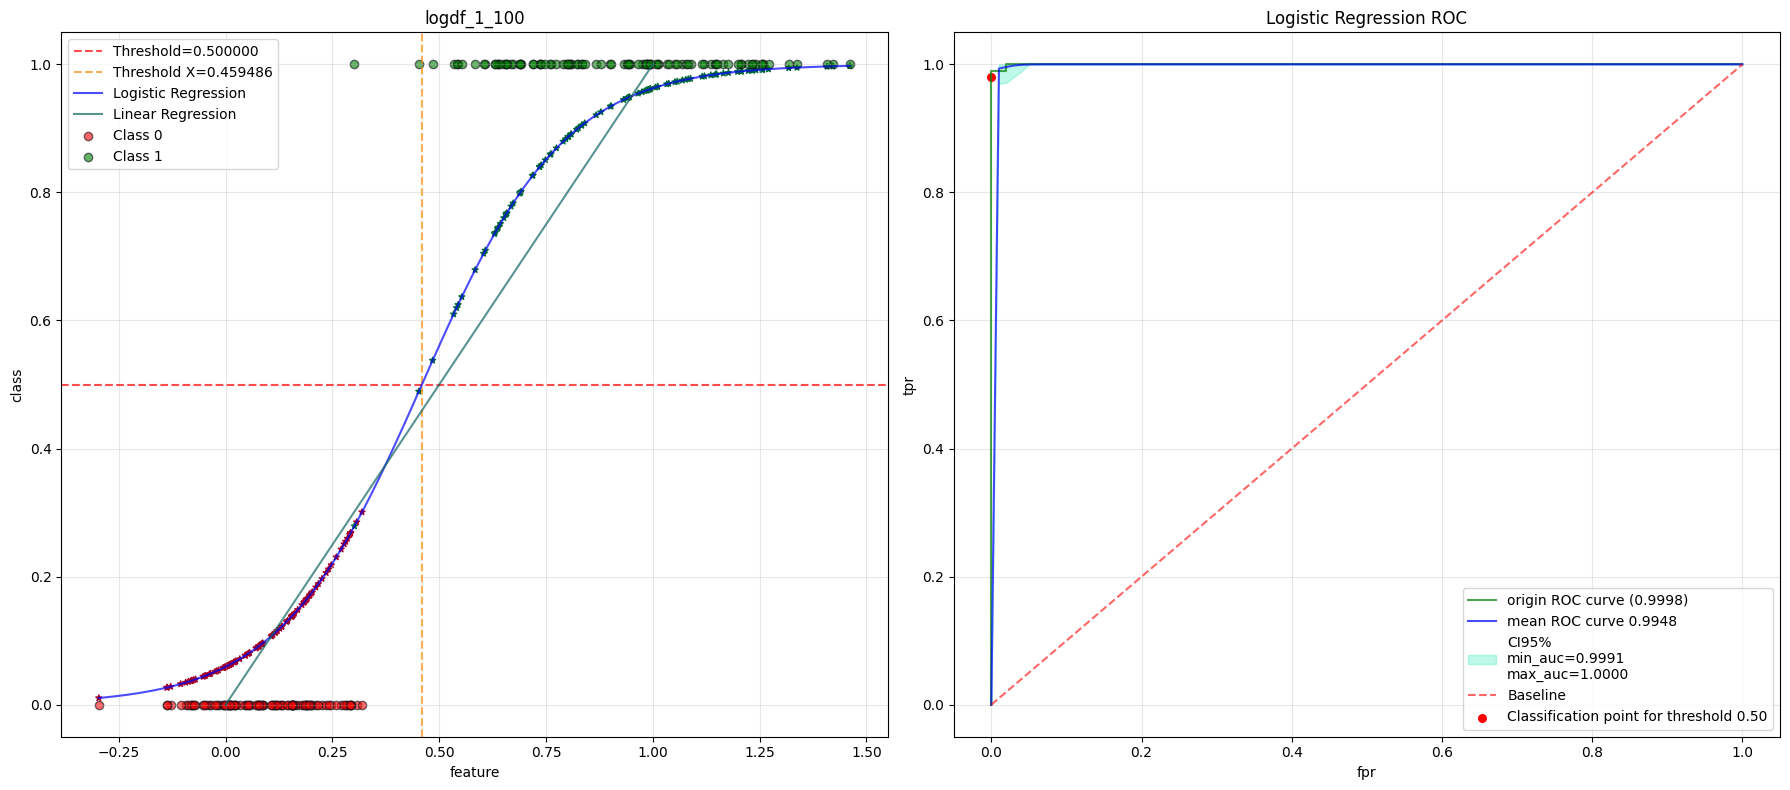

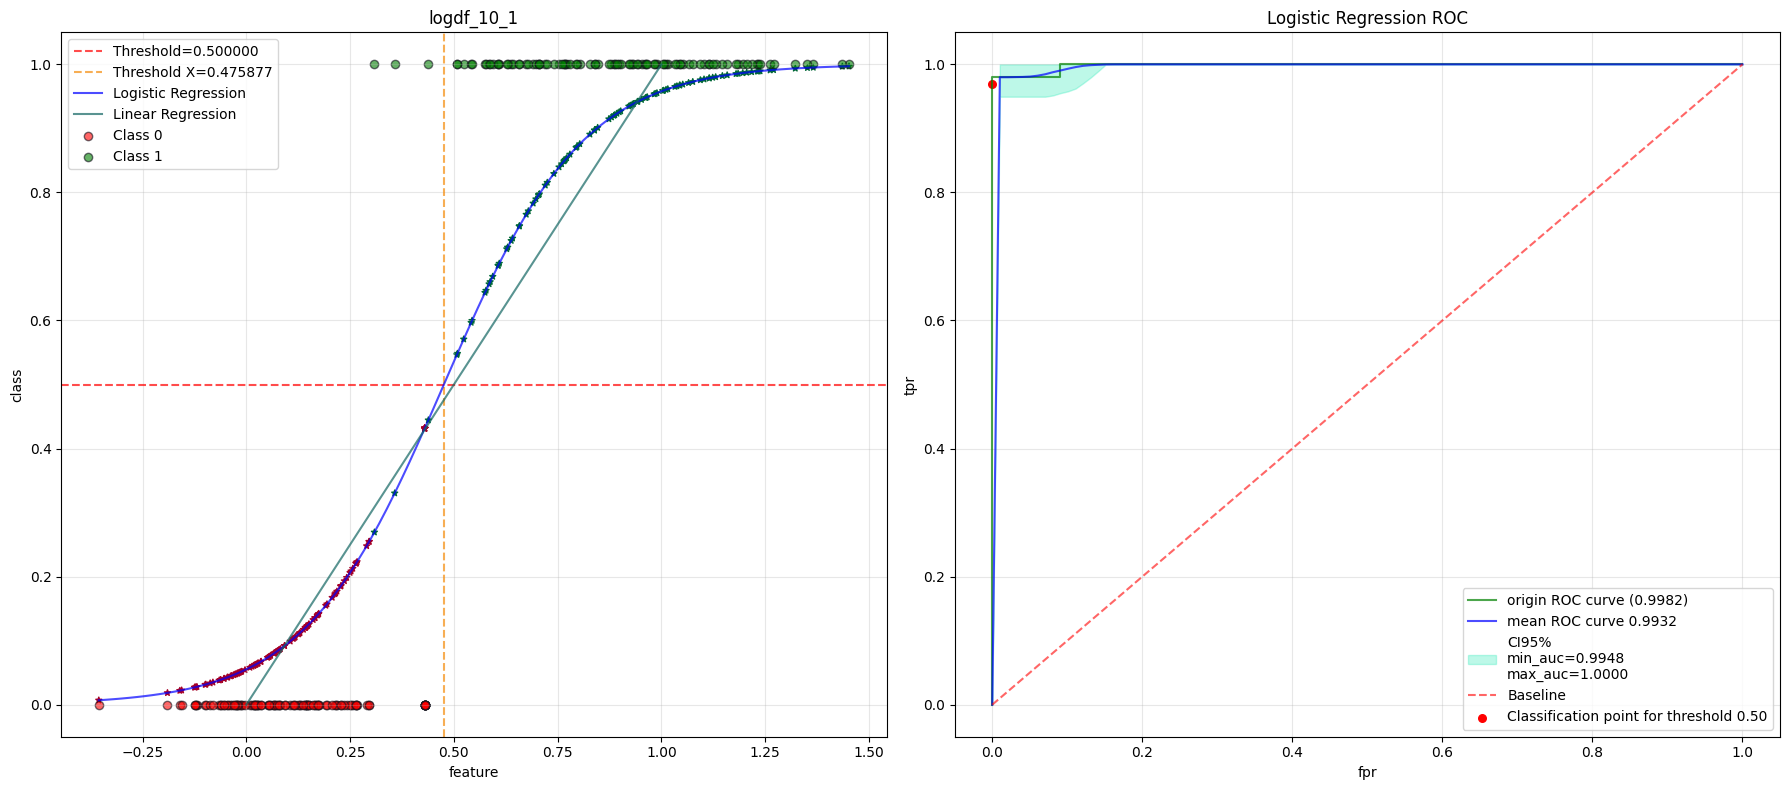

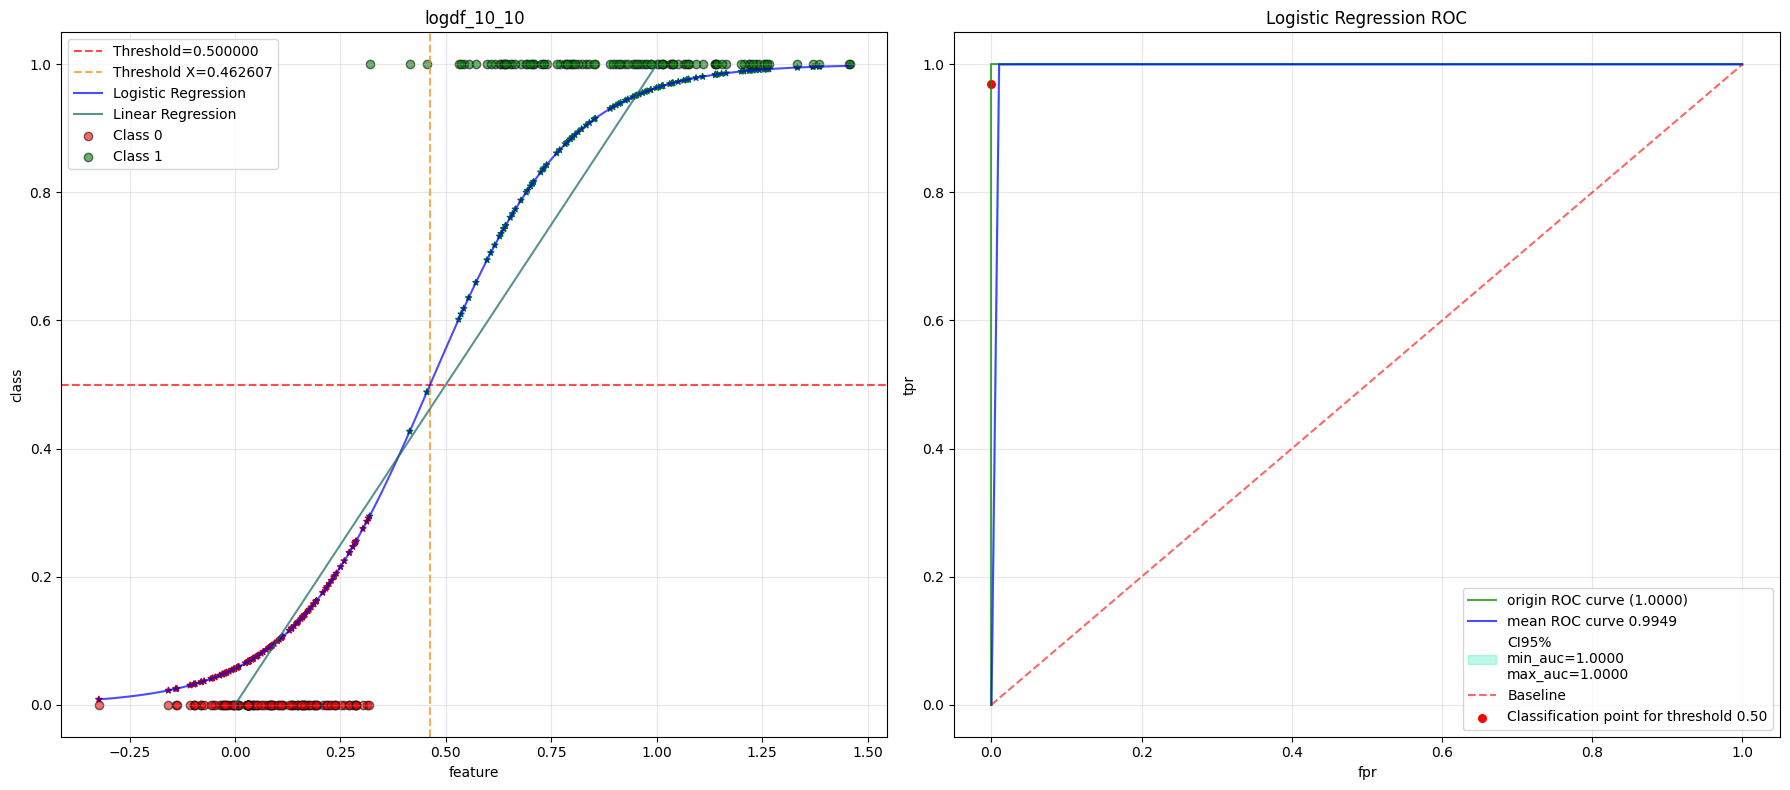

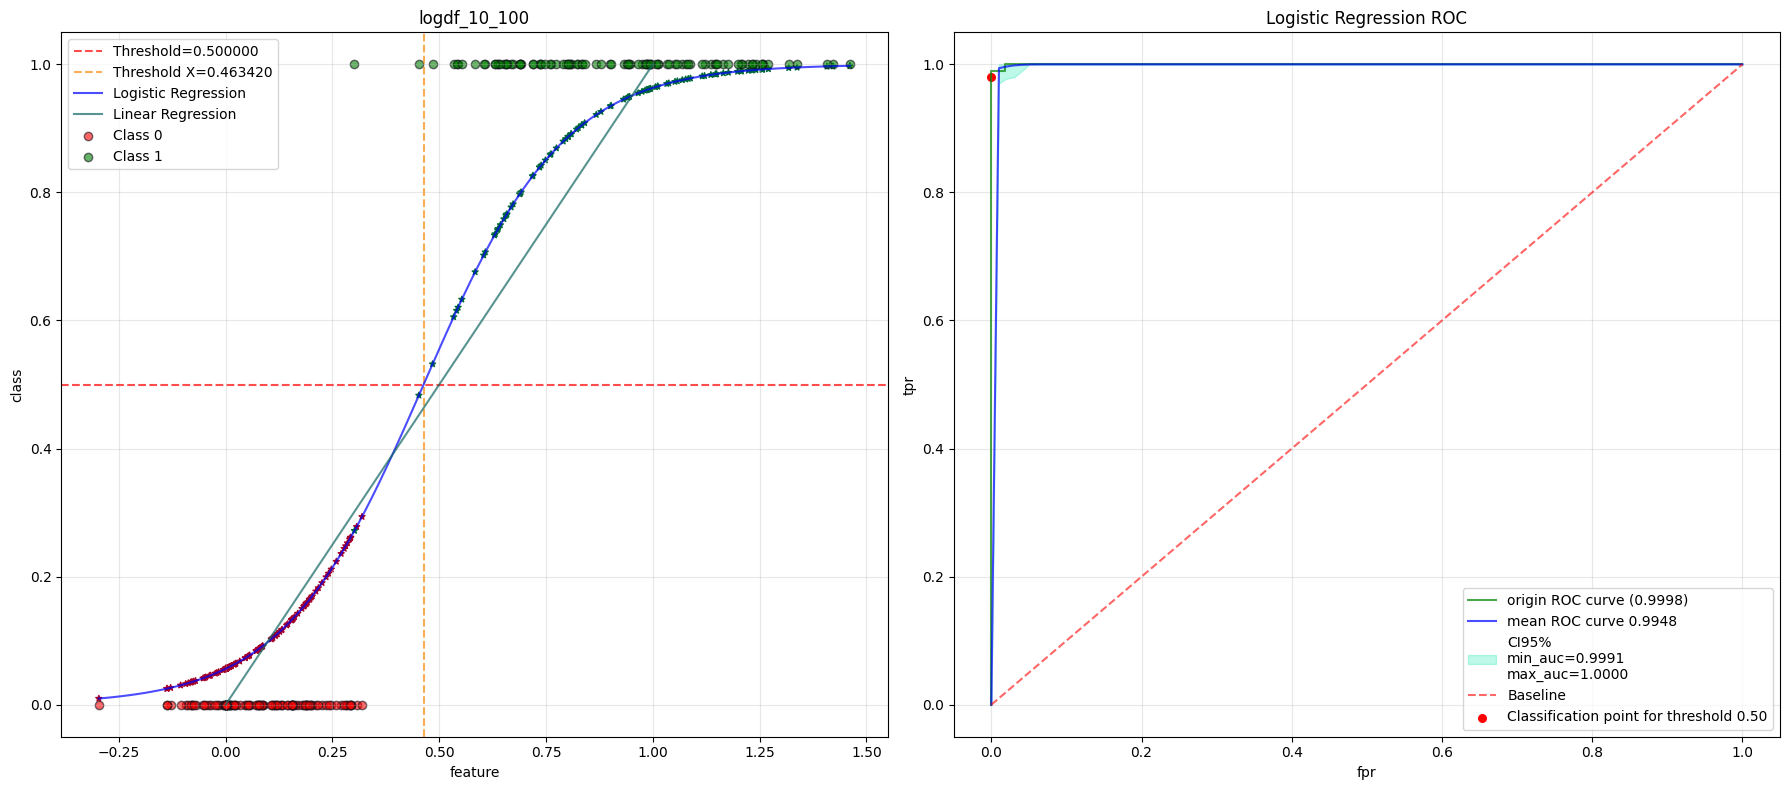

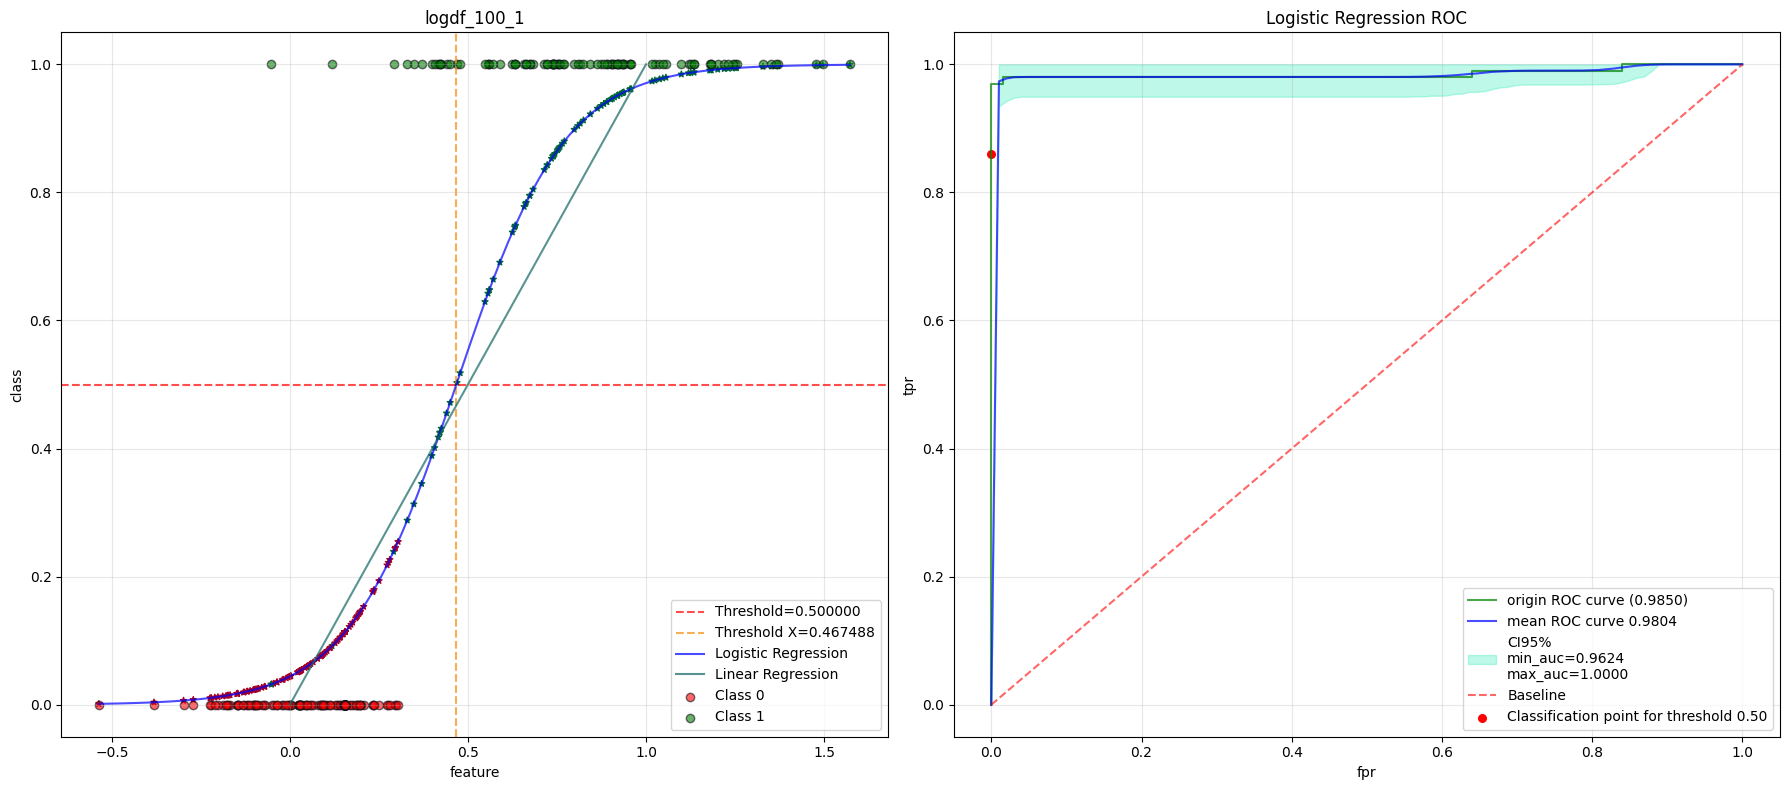

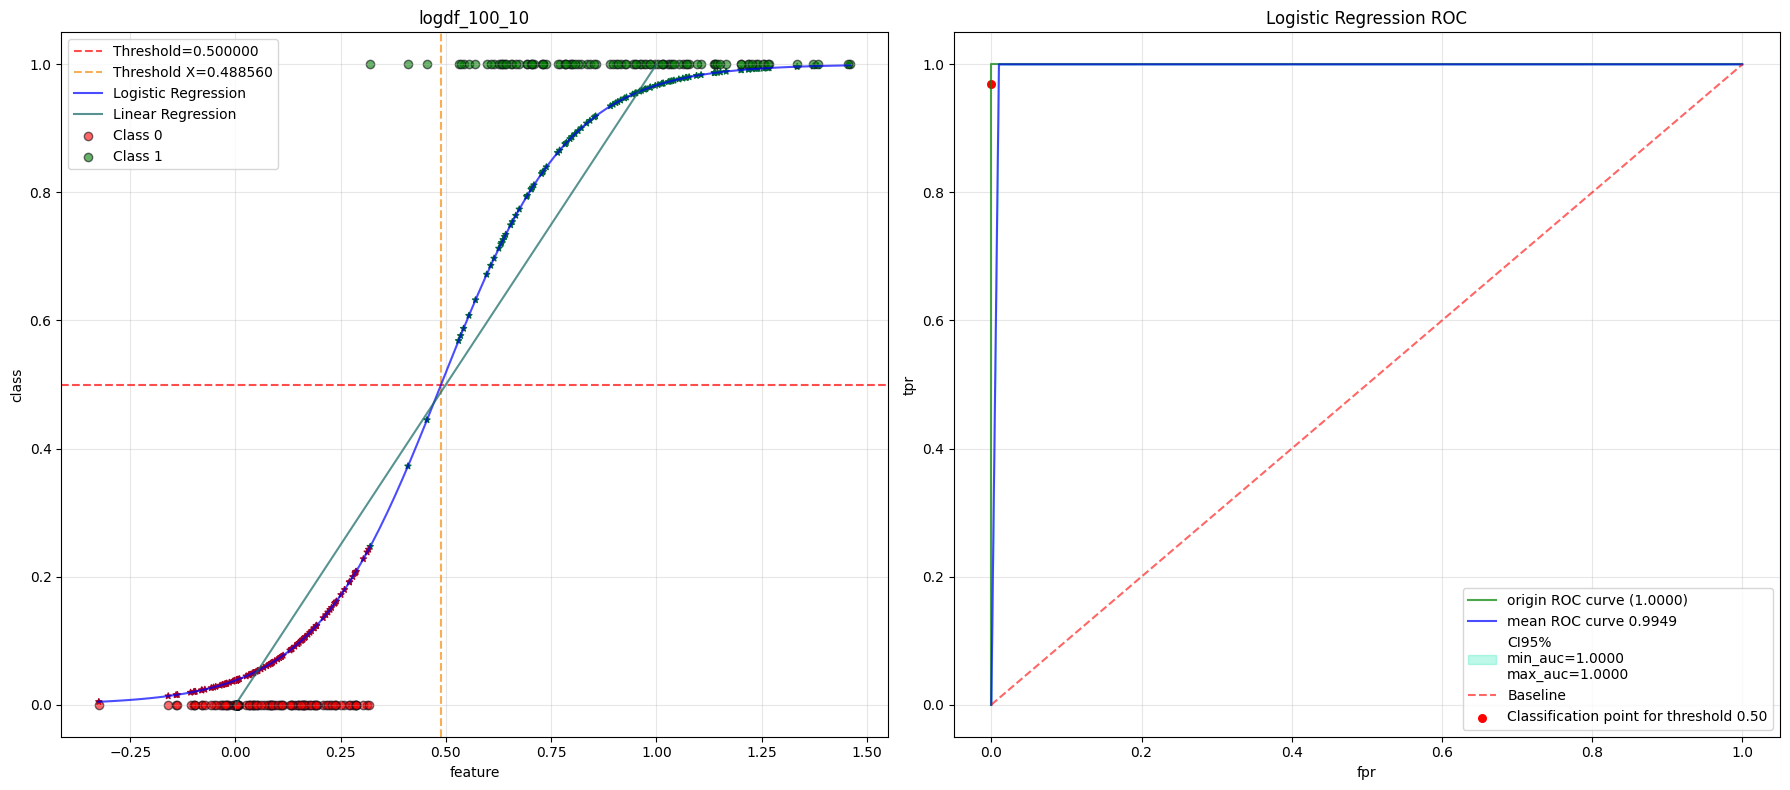

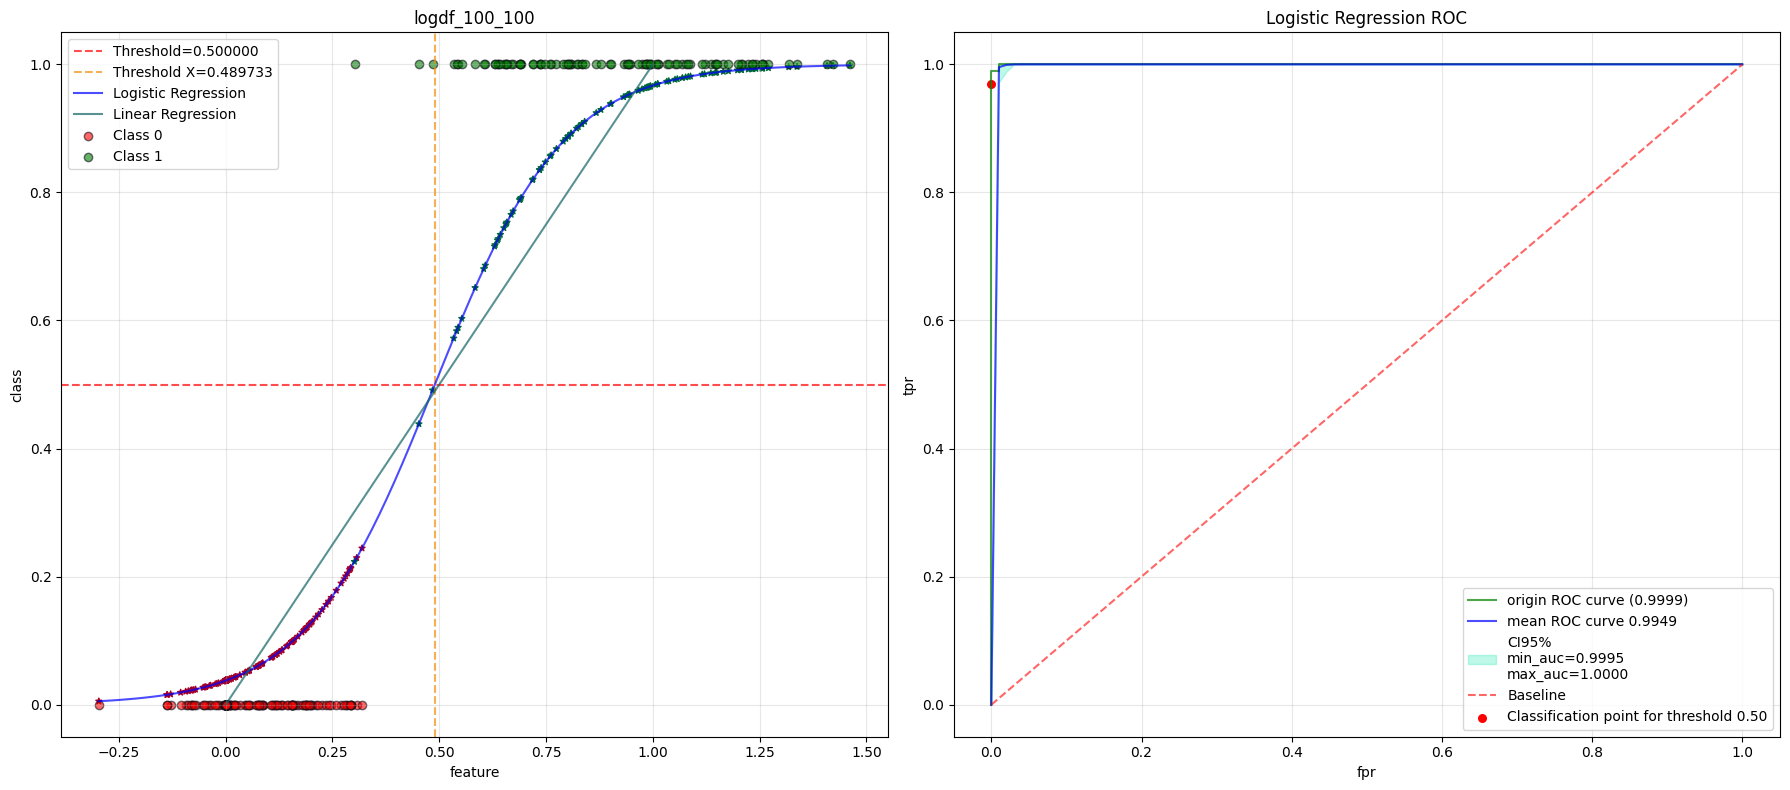

In [44]:
if CALC_T4T5:
    classes = [0, 1]
    features = COLUMNS[:4]
    
    logdata = create_log_data(data, classes, features)

    classes = [0, 1]

    plotters = make_models_and_plots(logdata, classes, "feature")

    for i, plotter in enumerate(plotters):
        plotter.tight_layout()
        plotter.save(f"{SAVE_DIR}/linreg_logdata_{i}.png")



 ### **Stage 5 (task 6):** _Visualize dataset on all pairs_

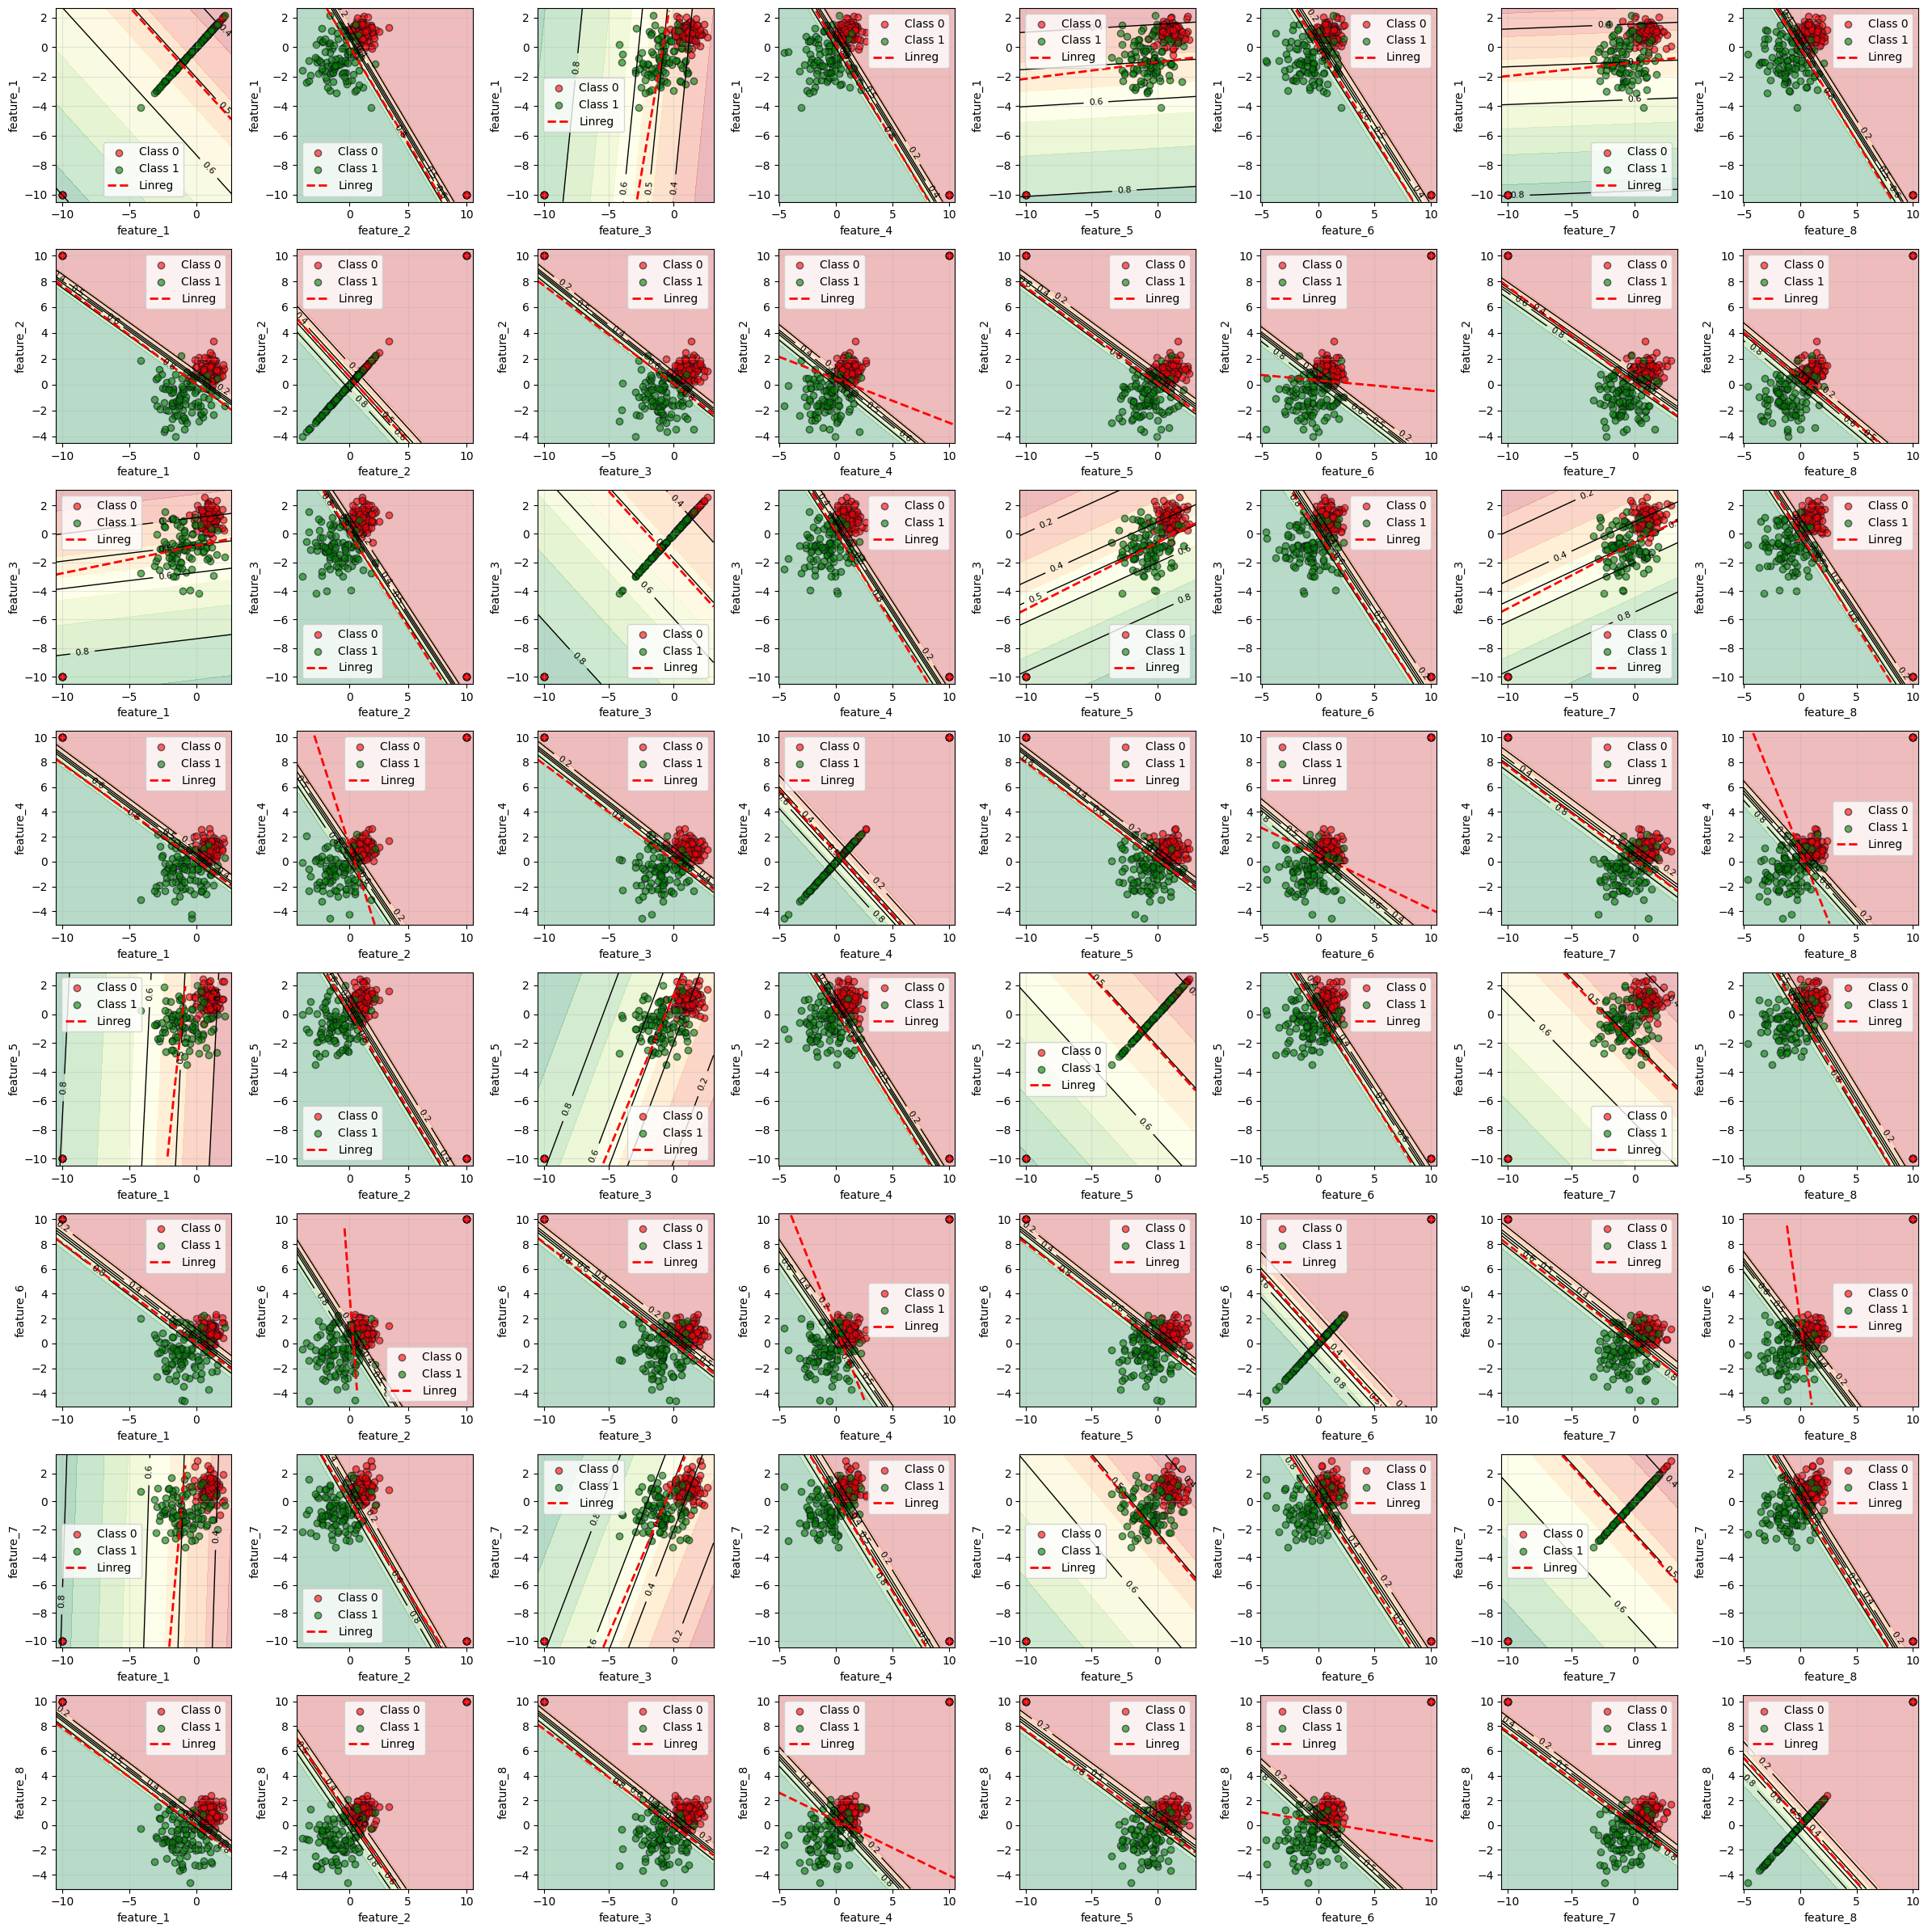

In [45]:
if CALC_T6:
    classes = [0, 1]
    df6 = data["df_10_10"]
    probability_levels = [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
    threshold = 0.5

    plotter = Plotter(nrows=8, ncols=8, figsize=(24, 24))

    for i, feature_y in enumerate(COLUMNS):
        for j, feature_x in enumerate(COLUMNS):

            ldf, lX, ly = filter_data(df6, classes, [feature_x, feature_y])
            class0_mask = ly == 0
            class1_mask = ly == 1
            
            log_reg = LogisticRegression()
            log_reg.fit(lX, ly)
            lin_reg = LinearRegression()
            lin_reg.fit(lX, ly)
            
            a, b = lin_reg.coef_
            c = lin_reg.intercept_

            k = -a / b
            b = (threshold - c) / b
            
            x1_min, x1_max = lX[:, 0].min() - 0.5, lX[:, 0].max() + 0.5
            x2_min, x2_max = lX[:, 1].min() - 0.5, lX[:, 1].max() + 0.5
            xp = np.linspace(x1_min, x1_max, 100)
            xx1, xx2 = np.meshgrid(xp, np.linspace(x2_min, x2_max, 100))
            
            yp = k * xp + b
            
            filter = (yp >= x2_min) & (yp <= x2_max)
            yp = yp[filter]
            xp = xp[filter]

            Z = log_reg.predict_proba(np.c_[xx1.ravel(), xx2.ravel()])[:, 1]
            Z = Z.reshape(xx1.shape)
            
            plotter.set_position(irow=i, icol=j)
            
            plotter.contourf(xx1, xx2, Z, alpha=0.3, cmap="RdYlGn")
            plotter.scatter(lX[:, 0][class0_mask], lX[:, 1][class0_mask], c="red", alpha=0.6, edgecolor=EDGECOLOR, label="Class 0")
            plotter.scatter(lX[:, 0][class1_mask], lX[:, 1][class1_mask], c="green", alpha=0.6, edgecolor=EDGECOLOR, label="Class 1")
            contour = plotter.contour(xx1, xx2, Z, levels=probability_levels, colors="black", linewidths=1)
            plotter.clabel(contour, inline=True, fontsize=8, fmt='%.1f')
            plotter.plot(xp, yp, color="red", linewidth=2, linestyle="--", label="Linreg")
            plotter.grid(True, alpha=0.3)
            plotter.labels(feature_x, feature_y, "")
            plotter.legend()

    plotter.tight_layout()
    plotter.save(f"{SAVE_DIR}/linreg_8x8.png")